## Clutter

In [17]:
import copy
from itertools import izip
from math import sqrt
import numpy as np
from operator import mul
import matplotlib.mlab as mlab
from scipy.stats import bernoulli, norm
import matplotlib.pyplot as plt
from matplotlib.mlab import bivariate_normal
%matplotlib inline 

In [18]:
d = 1
N = 50
w = 0.5
clutter_var = 10
prior_var = 100
tol = 10**4

In [19]:
def likelihood_aux(point, mu, variances):

    # multiply through the list univariates from all the parameters
    
    if variances < 0:
        x = reduce(mul, ((norm.pdf(pt_uni, mu_uni, sd)
                        for (pt_uni, mu_uni, sd)
                        in izip(point, mu, -np.sqrt(-variances)))))
    else:
        x = reduce(mul, ((norm.pdf(pt_uni, mu_uni, sd)
                        for (pt_uni, mu_uni, sd)
                        in izip(point, mu, np.sqrt(variances)))))
    return x


def gen_data():
    
    global N, d, clutter_var, w, prior_var

    # Define relevant distributions.
    ris_clutter = bernoulli(w).rvs
    clutter_uni = norm(0, sqrt(clutter_var))
    rclutter = lambda: [clutter_uni.rvs() for _ in xrange(d)]  # random variable describing clutter
    prior = norm(0., sqrt(prior_var))

    # Sample from the distributions.
    # mean in each dimension
    x = np.array([prior.rvs() for _ in xrange(d)])
    x_rvss = [norm(x_i).rvs for x_i in x]
    rx = lambda: [xrvs() for xrvs in x_rvss] # random variable describing target function
    
    # populate data
    data = np.vstack([(rclutter() if ris_clutter() else rx()) for _ in xrange(N)])

    return x, data

def generate_data(true_mean):
    global N, d, clutter_var, w, prior_var

    # Define relevant distributions.
    ris_clutter = bernoulli(w).rvs
    clutter_uni = norm(0, sqrt(clutter_var))
    rclutter = lambda: [clutter_uni.rvs() for _ in xrange(d)]  # random variable describing clutter
    
    prior = norm(0., sqrt(prior_var)) 
    print prior.rvs()

    # Sample from the distributions.
    
    # choose mean in each dimension
    x = np.array([prior.rvs() for _ in xrange(d)])
    x = true_mean
    x_rvss = [norm(x_i).rvs for x_i in x]
    rx = lambda: [xrvs() for xrvs in x_rvss] # random variable describing target function
    
    # populate data
    data = np.vstack([(rclutter() if ris_clutter() else rx()) for _ in xrange(N)])

    return x, data


def param_dist(new, old):
    """Measures distance between two vectors of parameters."""
    new_finfo = np.finfo(new.dtype)
    new_clipped = np.clip(new, new_finfo.min, new_finfo.max)
    old_finfo = np.finfo(old.dtype)
    old_clipped = np.clip(old, old_finfo.min, old_finfo.max)
    return max(np.sum(np.atleast_2d((new_clipped - old_clipped) ** 2), axis=1))



def update_plot(data, m_new, v_new, cavity_m, cavity_v, mi, vi, factors_used, x_true, pclutter, m_old, v_old):

    global w
    min_x = np.min(data, axis=0)[0]
    max_x = np.max(data, axis=0)[0]
    x = np.linspace(max_x + 1.1 * (min_x - max_x),
                         min_x + 1.5 * (max_x - min_x), 201)
    
    plt.figure(figsize=(20,10))
    
    # Draw the new posterior.
    post_pdf = norm(m_new[0], sqrt(v_new)).pdf
    plt.plot(x, map(post_pdf, x), label="new posterior")
    
    # Draw the old posterior.
    post_old_pdf = norm(m_old[0], sqrt(v_old)).pdf
    plt.plot(x, map(post_old_pdf, x), label="old posterior")
    
    # Draw the points used.
    plt.plot((x_true[0], x_true[0]), (0, 1.5), label="target mean")
    plt.scatter(data[factors_used, 0], np.zeros(len(factors_used)), color='b', label="used points")

    # Draw the cavity distribution.
    if cavity_v < 0:
        neg_var = -sqrt(-cavity_v)
        plt.plot(x, mlab.normpdf(x, cavity_m[0], neg_var), label="cavity")
    else:
        plt.plot(x, map(norm(cavity_m[0], sqrt(cavity_v)).pdf, x), label="cavity")
    
    # Draw the last point's distribution.
    last_point = data[factors_used[-1]][0]
    plt.scatter([last_point], [0.], color='g', label="latest data point")
    print "mean of factor ", mi[factors_used[-1], 0]
    if vi[factors_used[-1]] < 0:
        plt.plot(x, mlab.normpdf(x, mi[factors_used[-1], 0], -sqrt(-vi[factors_used[-1]])), label="updated factor")
    else:
        last_post_pdf = norm(mi[factors_used[-1], 0], sqrt(vi[factors_used[-1]])).pdf
        plt.plot(x, map(last_post_pdf, x), label="updated factor")
    plt.legend()
    plt.show()


def plot_factors(data, x_true, m_0, v_0, mi, vi):
    y_1d = np.atleast_2d(data)[...,0]
    min_x = min(y_1d)
    max_x = max(y_1d)
    x = np.linspace(max_x + 1.1 * (min_x - max_x), min_x + 1.5 * (max_x - min_x), 201)

    plt.plot((x_true[0], x_true[0]), (0, 0.5), label="true x")
    plt.scatter(y_1d, np.zeros(data.shape[0]))
    prior = norm(m_0[0], sqrt(v_0)).pdf
    plt.plot(x, map(prior, x), label="prior")

    for i, (mi, vi) in enumerate(izip(mi, vi)):
        if vi < 0:
            x_post = norm(mi[0], -sqrt(-vi)).pdf
            plt.plot(x, mlab.normpdf(x, mi[0], -sqrt(-vi)), label="true factor")
        else:
            x_post = norm(mi[0], sqrt(vi)).pdf
            plt.plot(x, map(x_post, x))
    plt.legend()
    plt.show()




2.70002234253
[2]


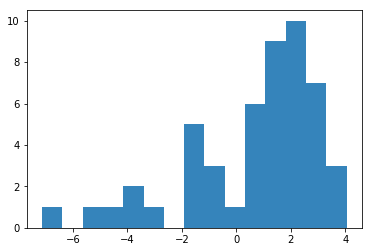

In [20]:
# generate data

# x_true, data = gen_data()

target = np.array([2])
x_true, data = generate_data(target)

print x_true

plt.hist(data, bins=15, alpha=0.9)
plt.show()

In [21]:
# Initialise the prior (not to change it ever more).
m0 = np.zeros(d)  # The prior of x shall be non-informative.
v0 = prior_var
s0 = (2 * np.pi * v0) ** (-.5 * d)

# Initialise data terms.
vi = np.repeat(np.infty, N)
mi = np.zeros((N, d))
si = np.ones(N)
old_vi = copy.copy(vi)
old_mi = copy.copy(mi)
old_si = copy.copy(si)

# Initialise posterior with prior 
m_new = m0
v_new = v0


d_zeros = np.zeros(d)
d_clutter_vars = np.repeat(clutter_var, d)
pclutter = lambda y: likelihood_aux(y, d_zeros, d_clutter_vars)
# print pclutter


In [22]:
def division_zero(v1, v2):
    # check if the variances divide by zero
    inv_v1 = 1. / v1
    inv_v2 = 1. / v2
    if inv_v1 == inv_v2:
        return False
    else:
        return True
    
    
def remove_factor(mi, vi, m_new, v_new):
    # remove factor from posterior
    inv_vi = 1. / vi
    inv_v_new = 1. / v_new
    cavity_v = 1. / (inv_v_new - inv_vi)
    cavity_m = cavity_v * (m_new * inv_v_new - mi * inv_vi)
    
    return cavity_m, cavity_v

def minimise_KL_divergence(data_point, cavity_m, cavity_v):
    
    Zi = ((1 - w) * likelihood_aux(data_point, cavity_m, np.repeat(cavity_v + 1., d)) + w * pclutter(data_point))
    r = 1. - w * pclutter(data_point) / Zi

    m_new = (cavity_m + r * cavity_v / (1. + cavity_v) * (data_point - cavity_m))

    v_new = (cavity_v - r * (cavity_v ** 2) / (cavity_v + 1.) +
               r * (1 - r) * cavity_v ** 2
               * np.sum((data_point - cavity_m) ** 2)
               / (d * (cavity_v + 1.) ** 2))
    
    return m_new, v_new, Zi


def update_approximate_factor(cavity_m, m_new, cavity_v, v_new, Zi):
    
    global d 

    inv_cavity_v = 1. / cavity_v
    inv_new_v = 1. / v_new
    
    # problem 1
    # division by zero
    if division_zero(cavity_v, v_new):
        vi = 1. / (inv_new_v - inv_cavity_v)
    else:
        vi = np.infty
        print "same variance from removing new approximate factor iiii"
    
    # problem 2
    # 0 * infinity
    if vi == np.infty and (inv_cavity_v == 0 or any(m_new == cavity_m)):
        mi = cavity_m
        # mi = vi * (inv_new_v * m_new - inv_cavity_v * cavity_m)
        print "0*infinity iiii"
        print inv_cavity_v
    else:
        mi = vi * (inv_new_v * m_new - inv_cavity_v * cavity_m)
        # mi = cavity_m + (vi + cavity_v) * inv_cavity_v * (m_nenw - cavity_m)
    
    
    # calculate normalising constant
    m_prob = likelihood_aux(mi, cavity_m,np.repeat(vi + cavity_v, d))
    si = Zi / m_prob if m_prob > 0. else np.infty    

    return mi, vi, si

def check_convergence(mi, vi, si, old_mi, old_vi, old_si):

    dist = max(param_dist(new, old) for (new, old) in ((vi, old_vi), (mi, old_mi), (si, old_si)))
    print "m_new = ", m_new, " v_new = ", v_new
    print "Maximum distance from last parameter values: ", dist
    
    if dist <= tol:
        return True
    else:
        return False

In [23]:
print m_new
print cavity_m
print any(m_new == 0)

[ 0.]
[ 9.68869508]
True


Iteration  0
factor  0
mean of factor  1.67225855967


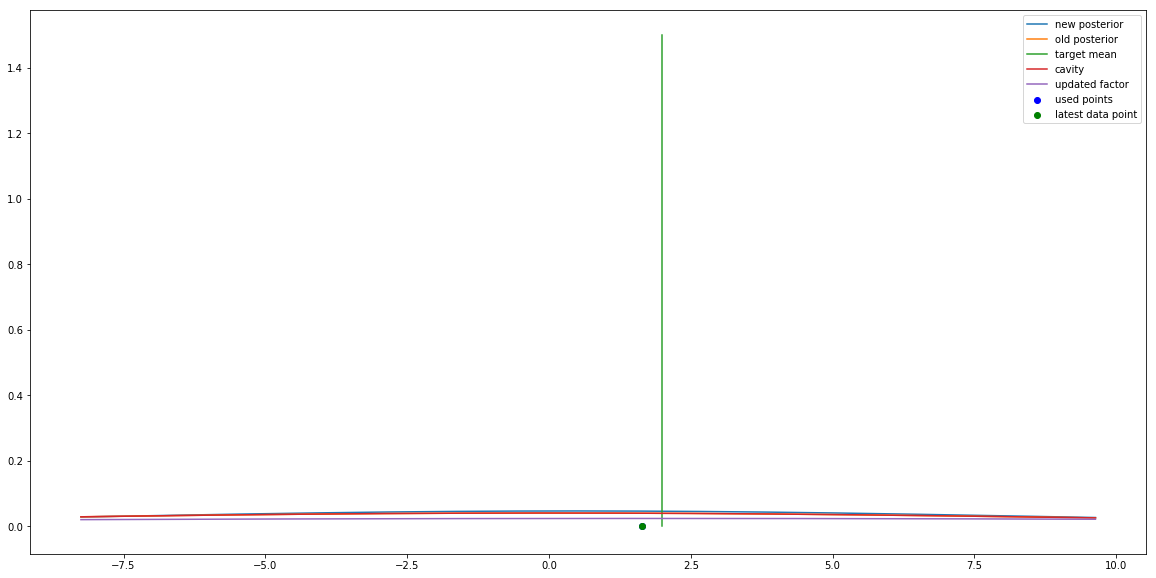

factor  1
mean of factor  -0.997960409118


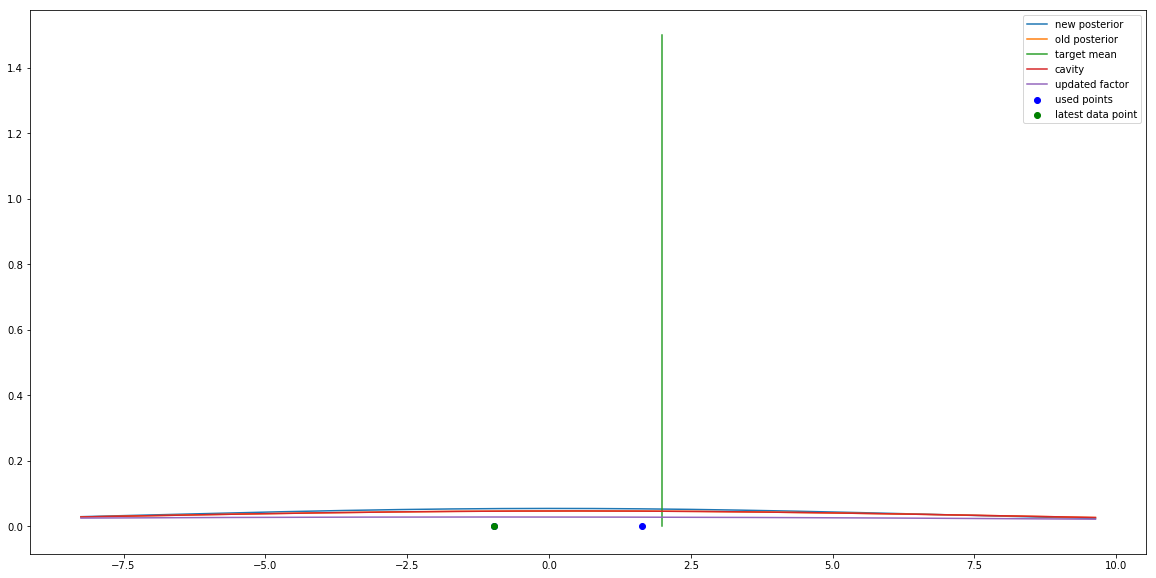

factor  2
mean of factor  2.06122602839


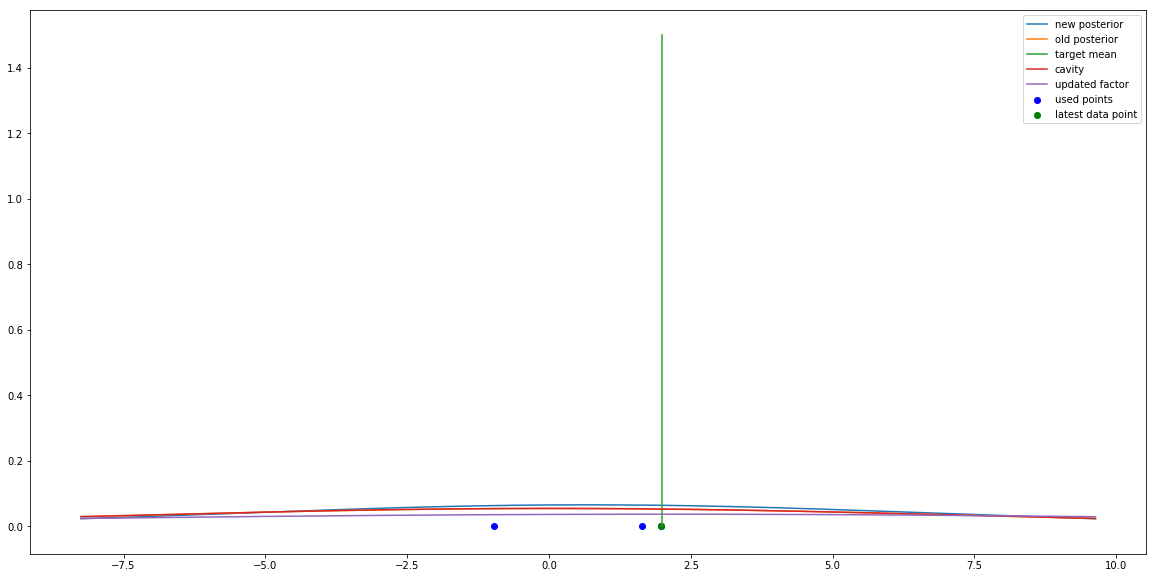

factor  3
mean of factor  2.03579182695


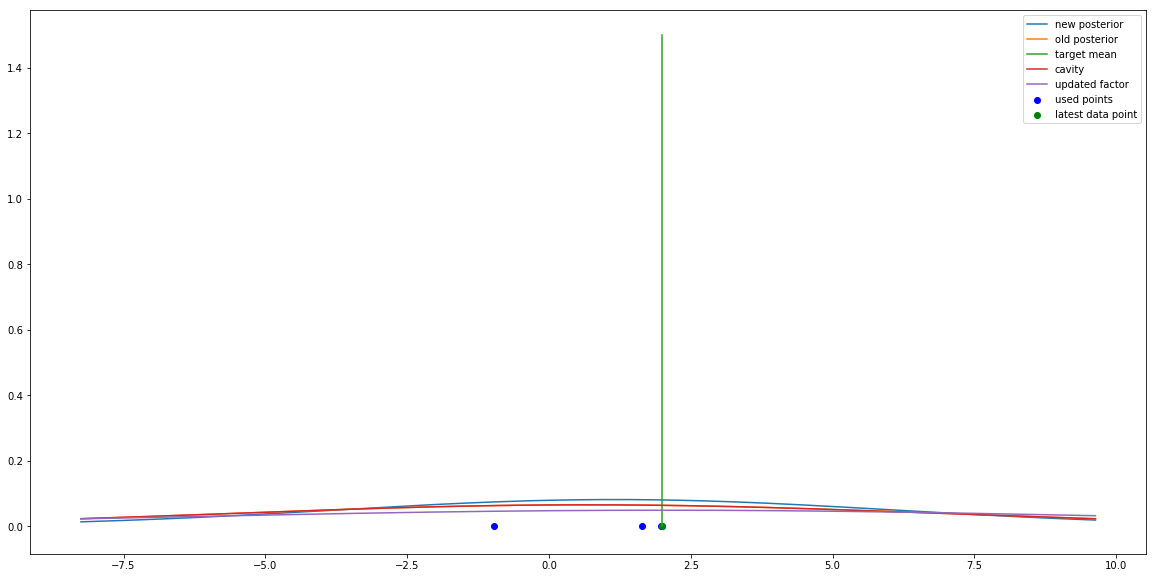

factor  4
mean of factor  3.52396912467


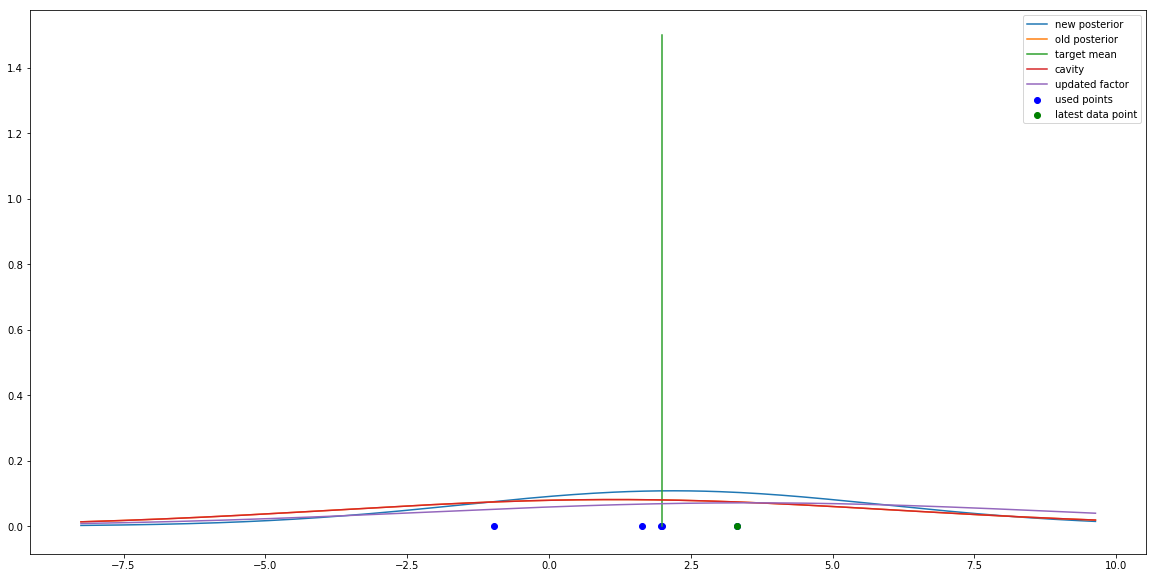

factor  5
mean of factor  0.442658149208


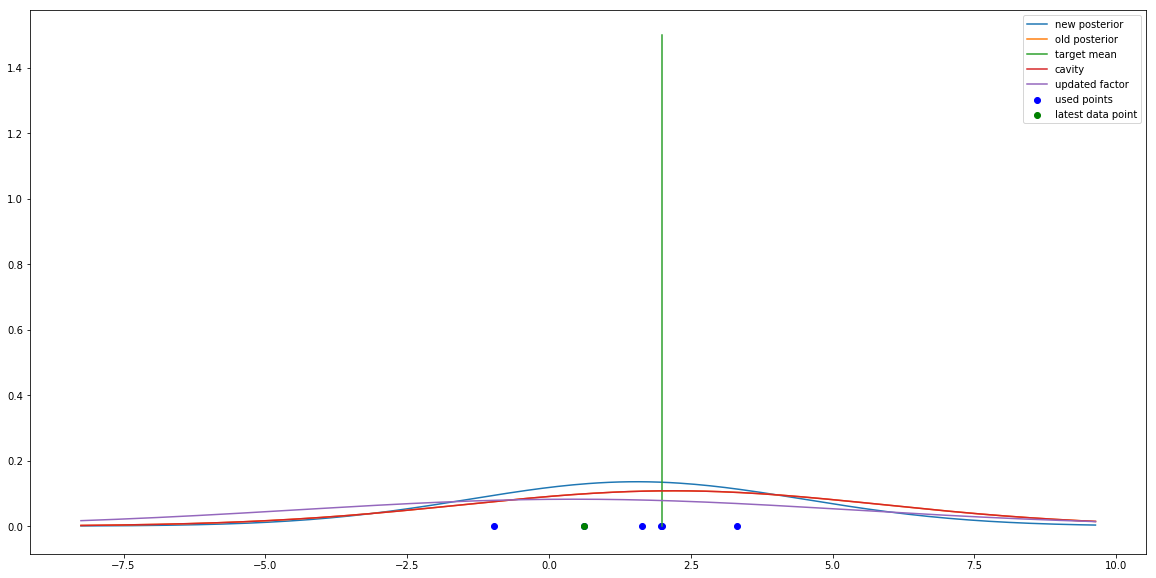

factor  6
mean of factor  7.22435417479


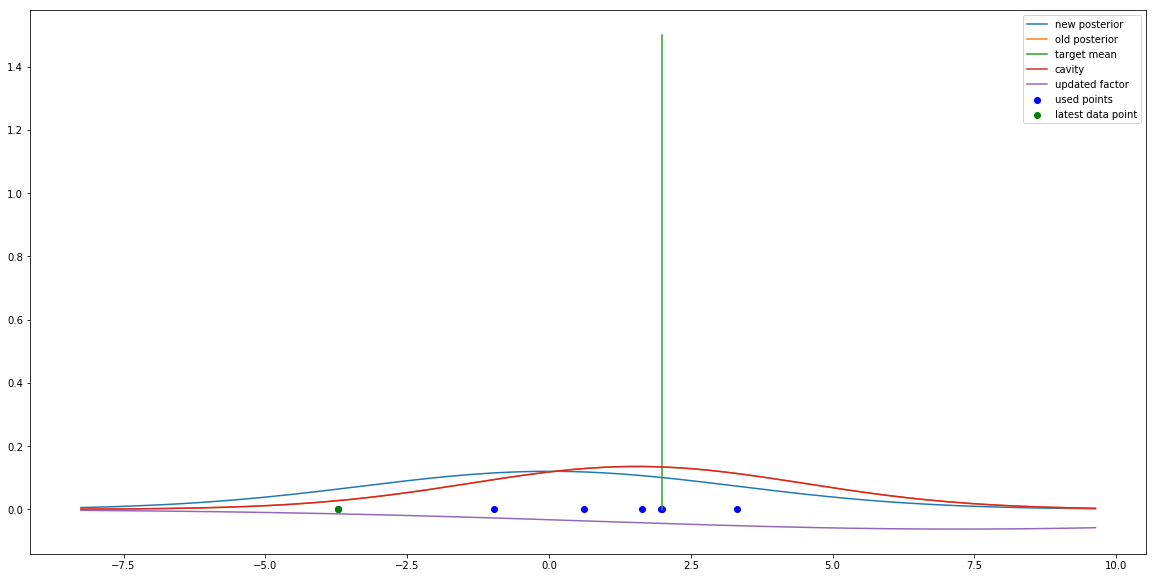

factor  7
mean of factor  0.614736513401


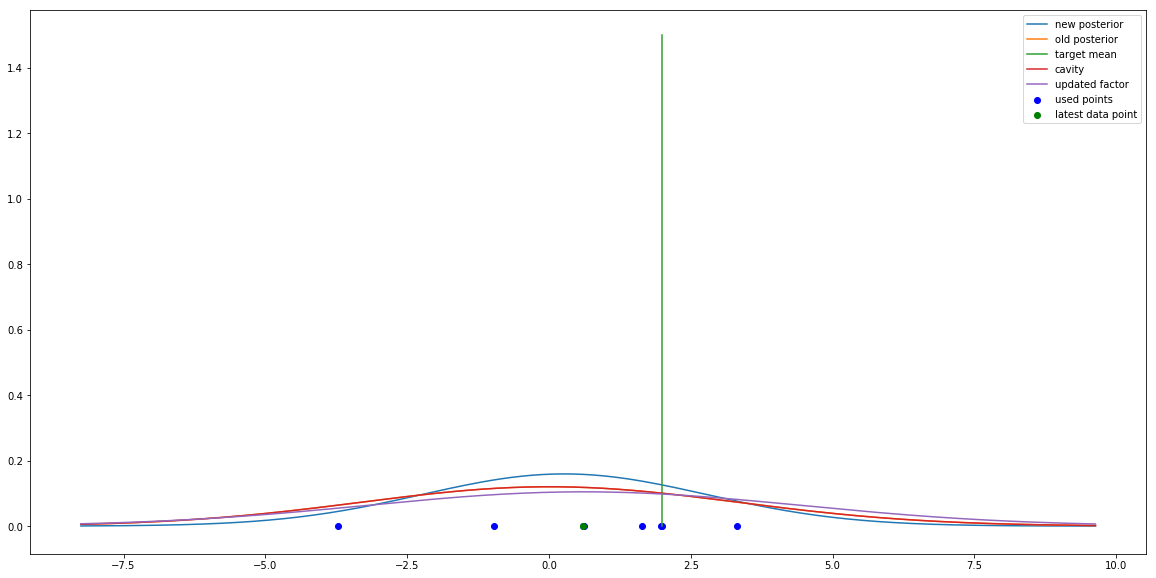

factor  8
mean of factor  1.3588170383


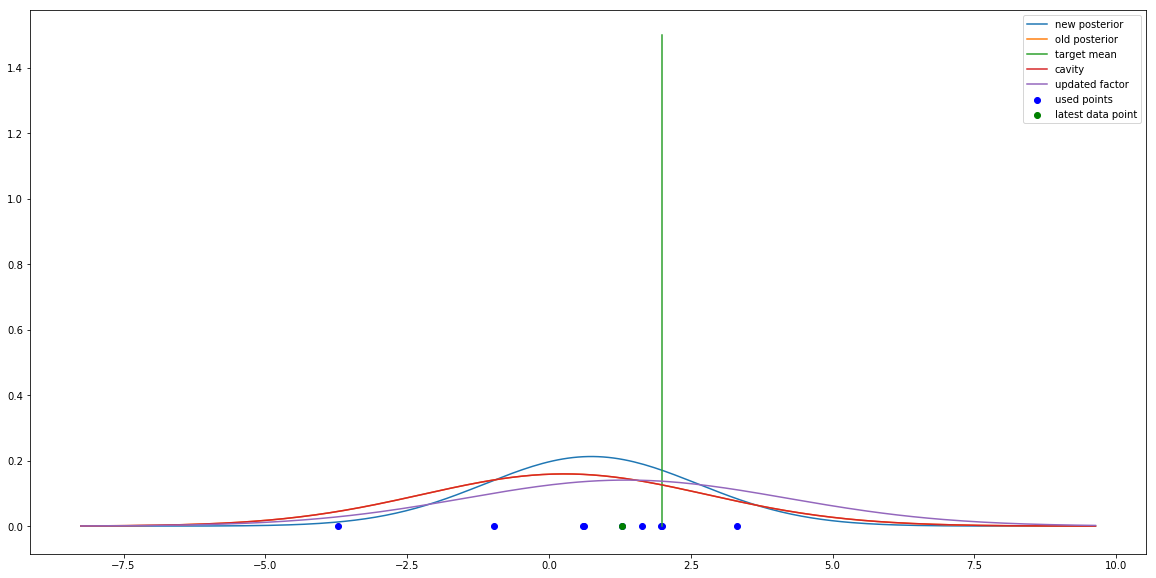

factor  9
mean of factor  2.07257845276


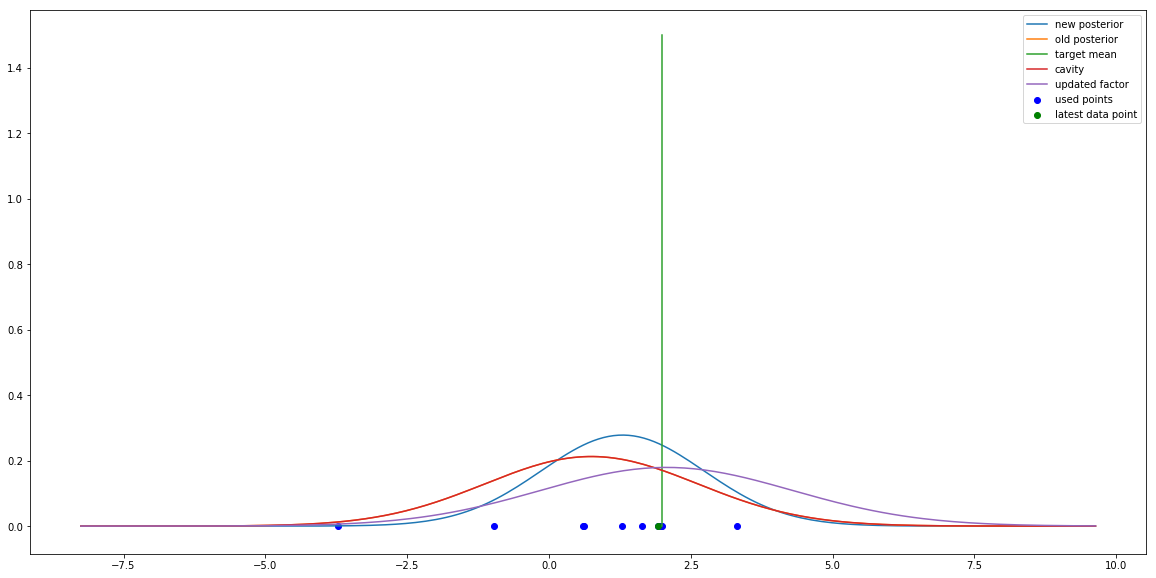

factor  10
mean of factor  0.698769685102


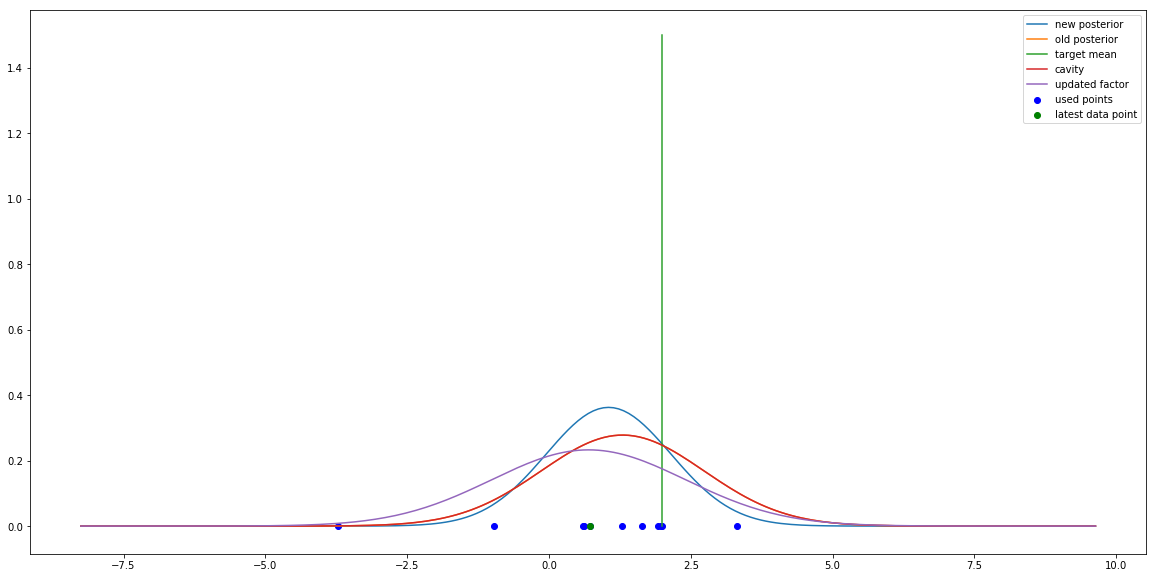

factor  11
mean of factor  0.742408503645


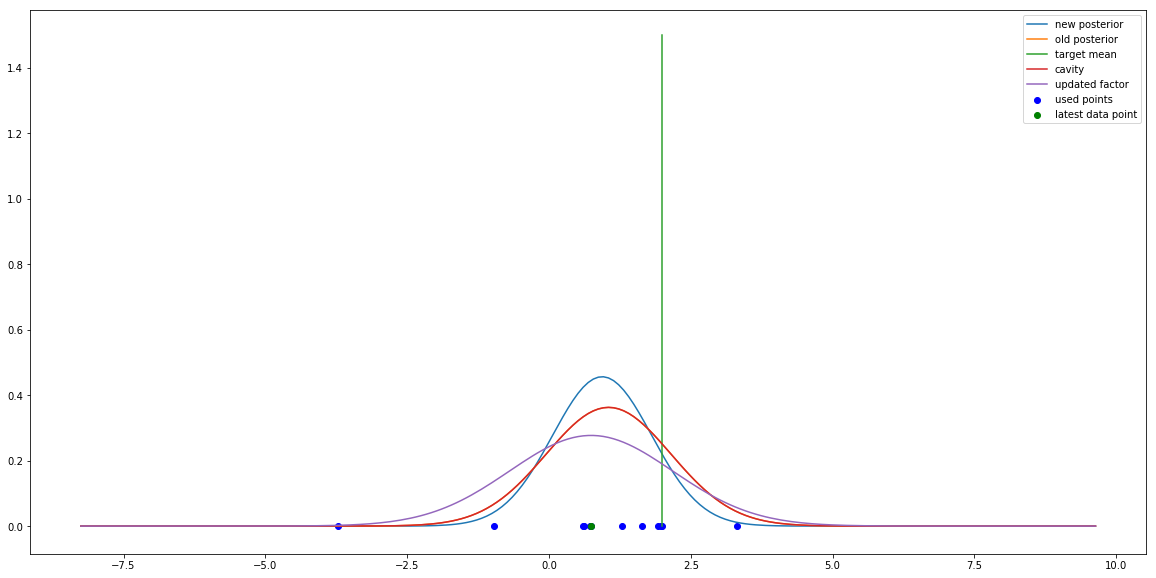

factor  12
mean of factor  13.4919159236


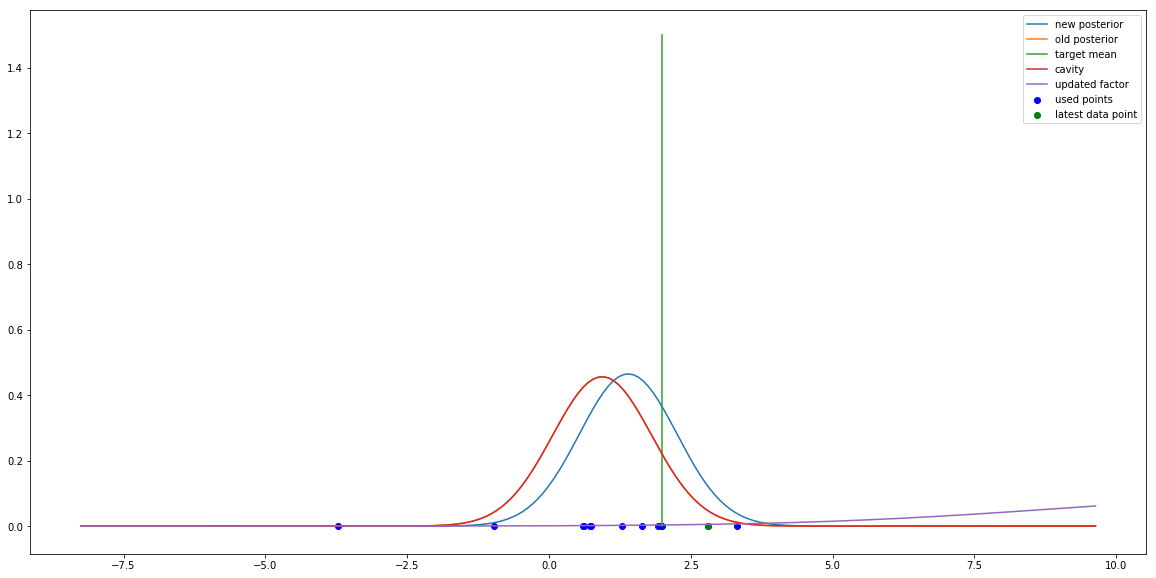

factor  13
mean of factor  4.04186555124


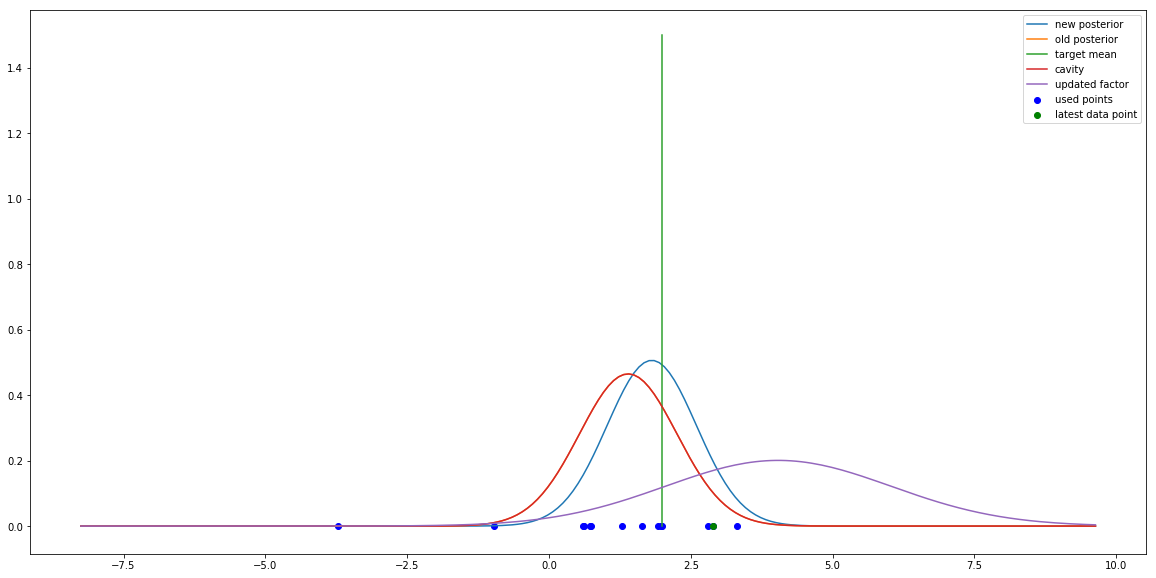

factor  14
mean of factor  2.46503822253


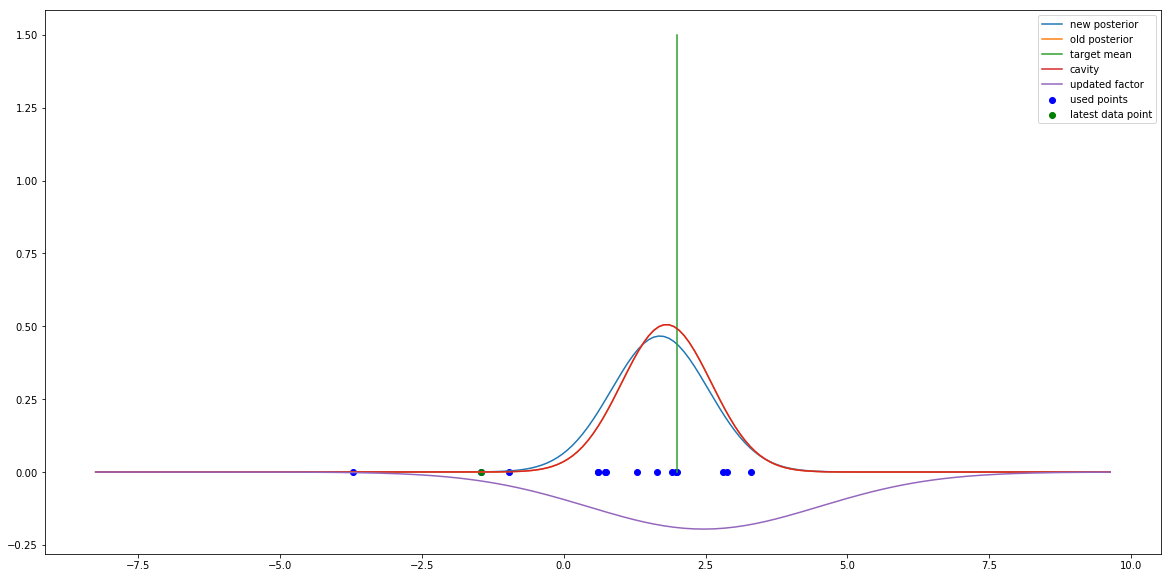

factor  15
mean of factor  2.51937259672


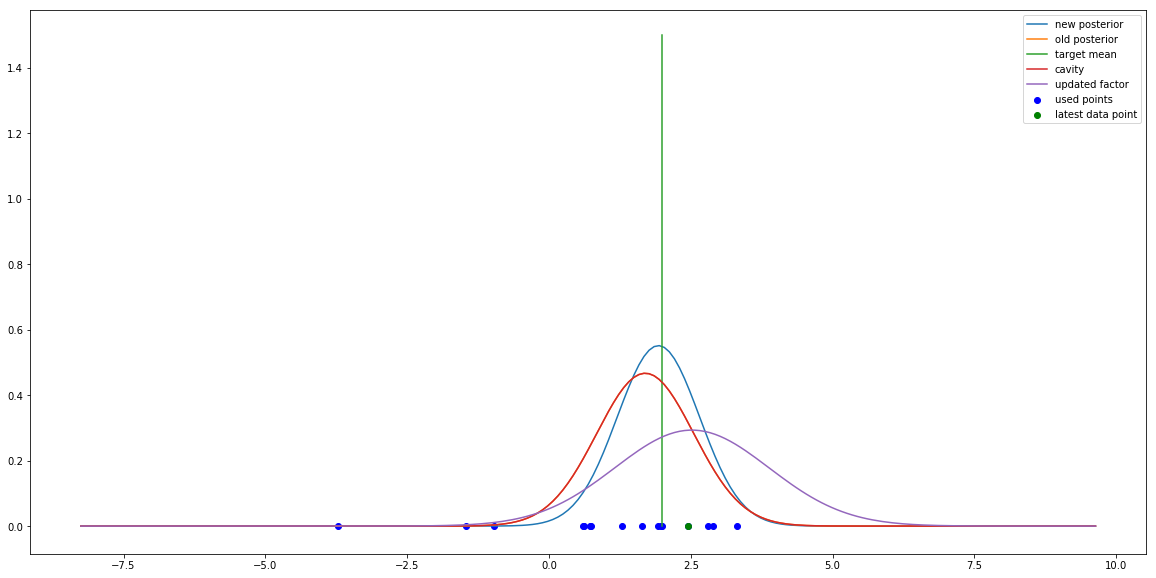

factor  16
mean of factor  -10.3114363933


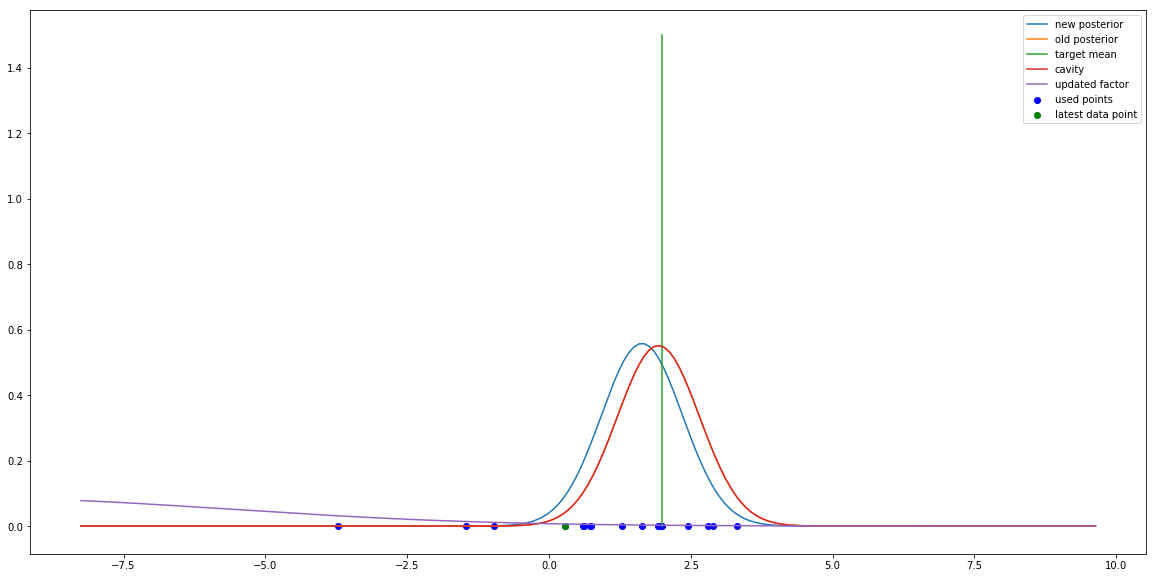

factor  17
mean of factor  2.23190649741


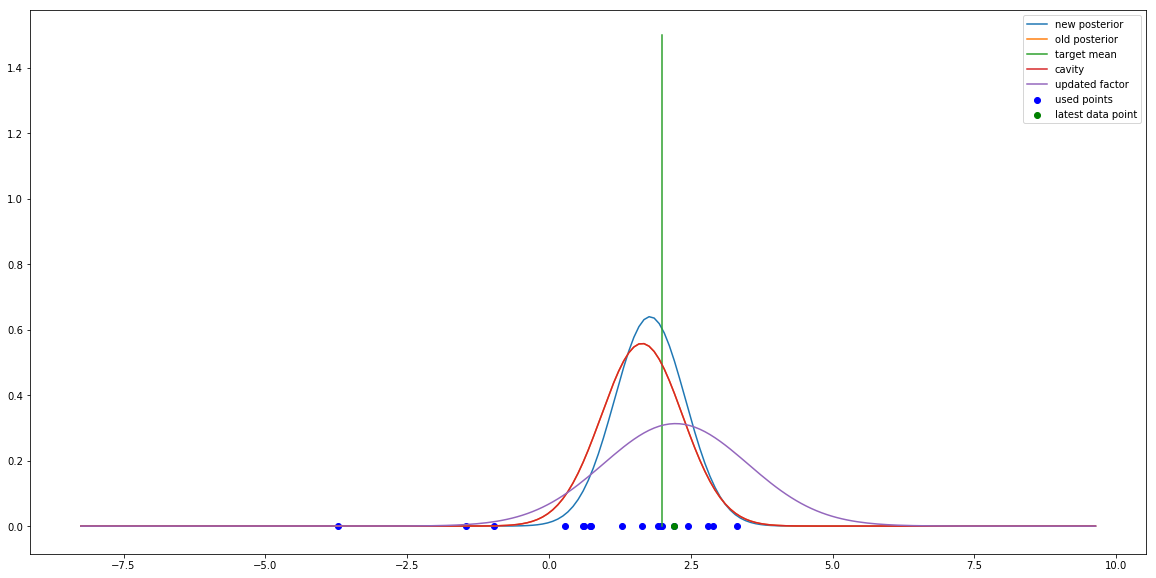

factor  18
mean of factor  1.89095248702


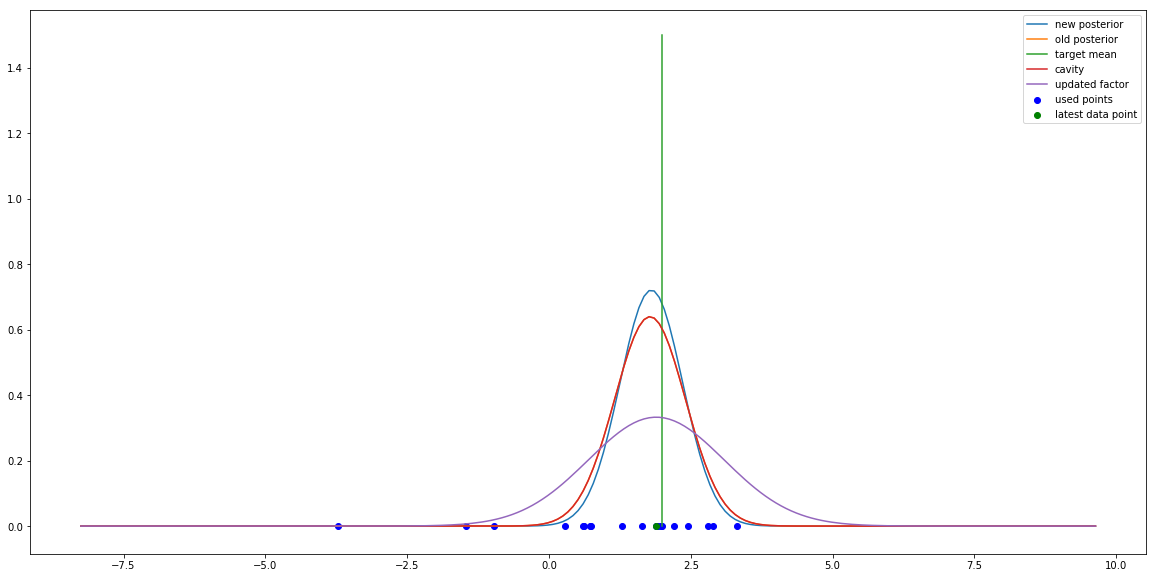

factor  19
mean of factor  2.37984436305


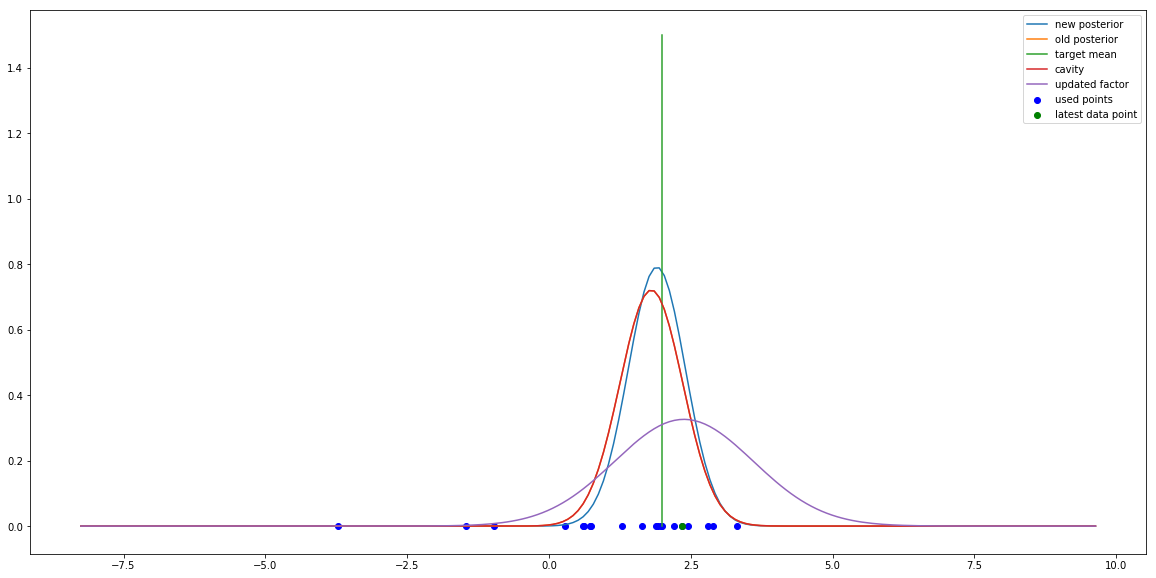

factor  20
mean of factor  2.36150132435


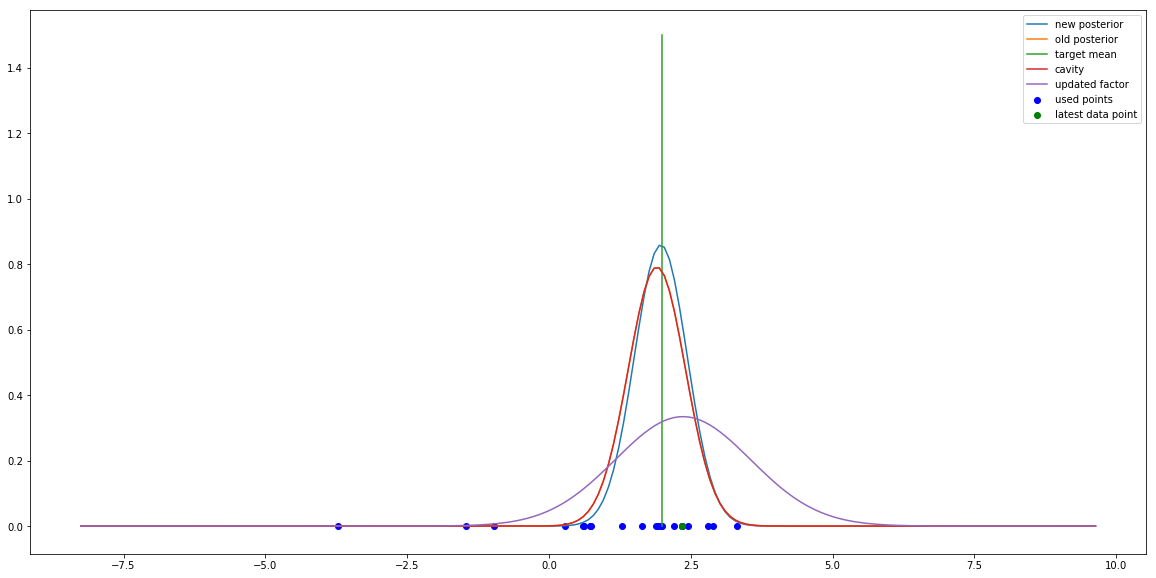

factor  21
mean of factor  4.1296479306


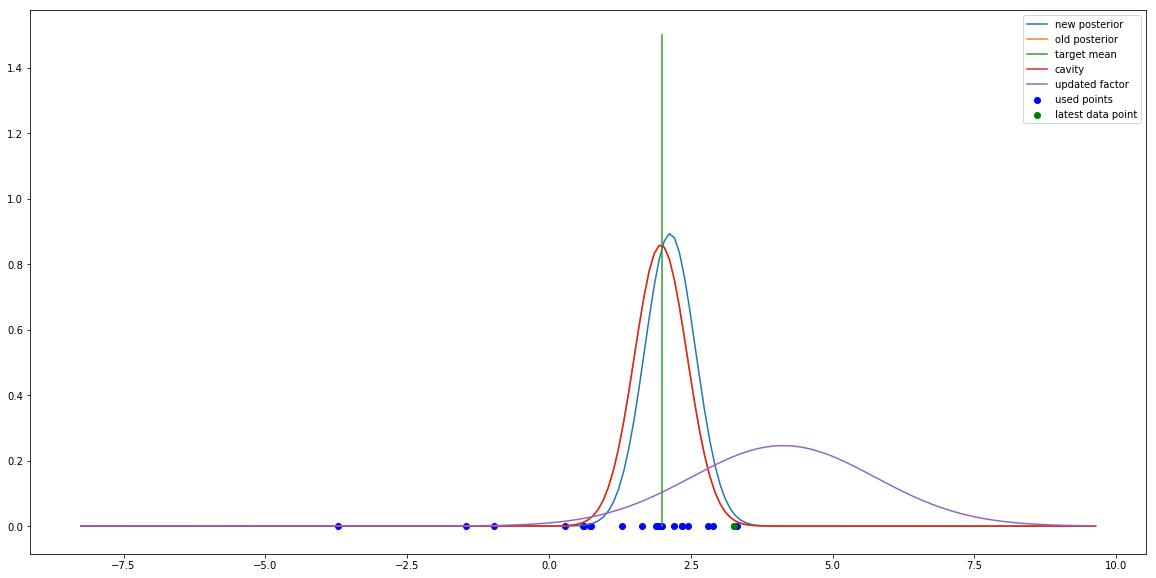

factor  22
mean of factor  2.97312482745


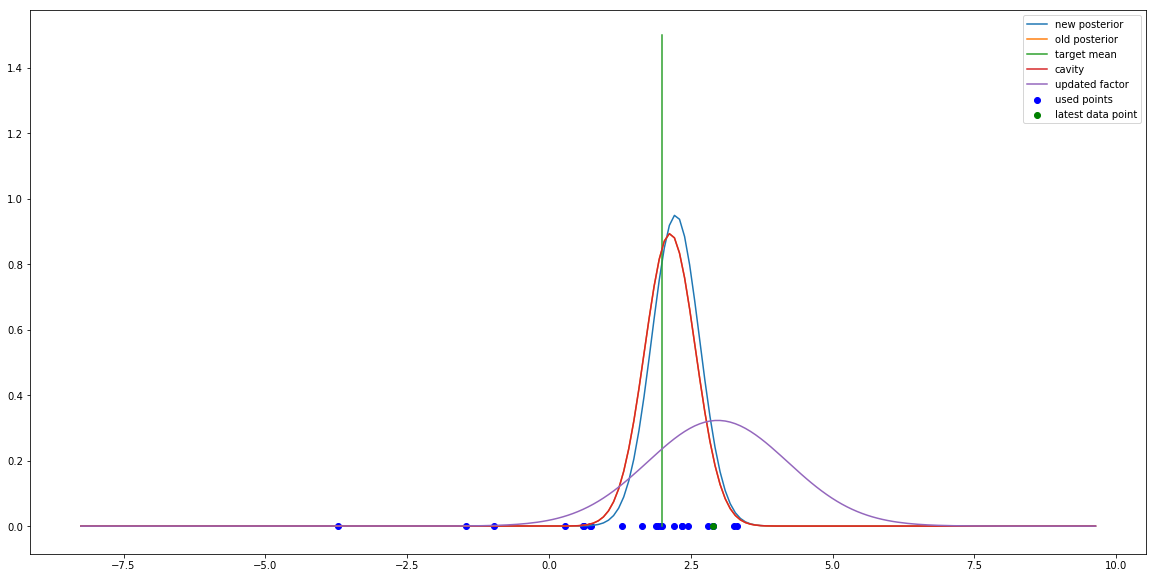

factor  23
mean of factor  1.20304224442


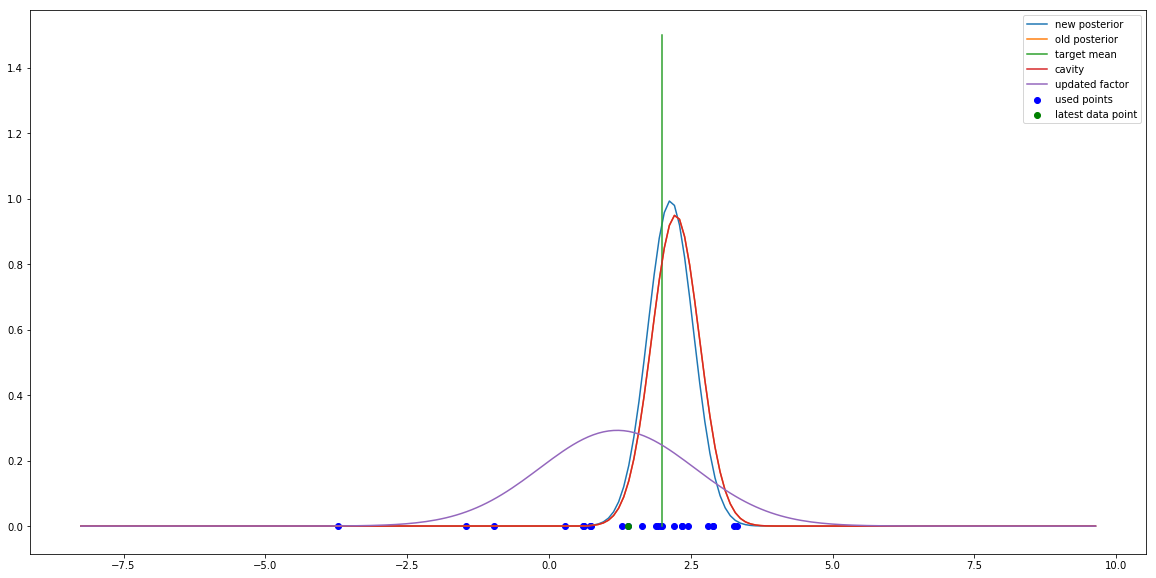

factor  24
mean of factor  2.30414035781


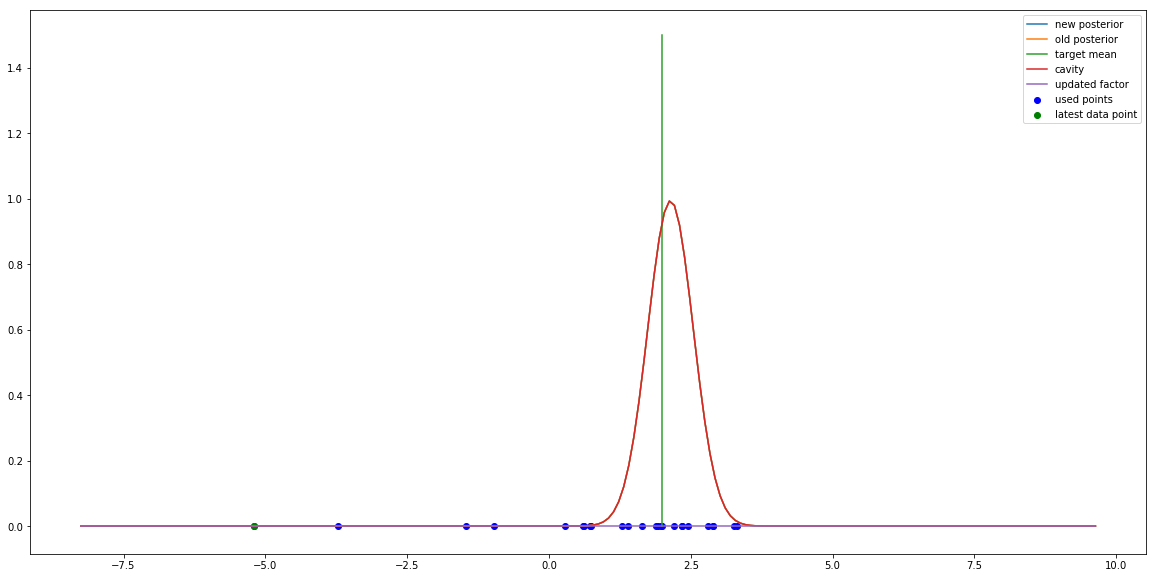

factor  25
mean of factor  1.7033329615


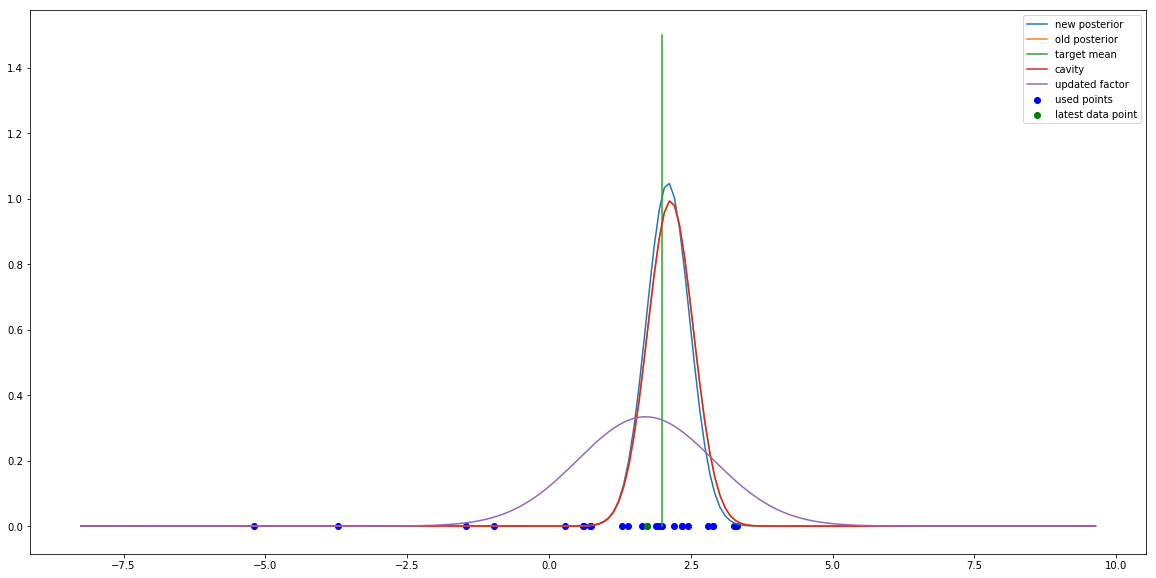

factor  26
mean of factor  4.12236968458


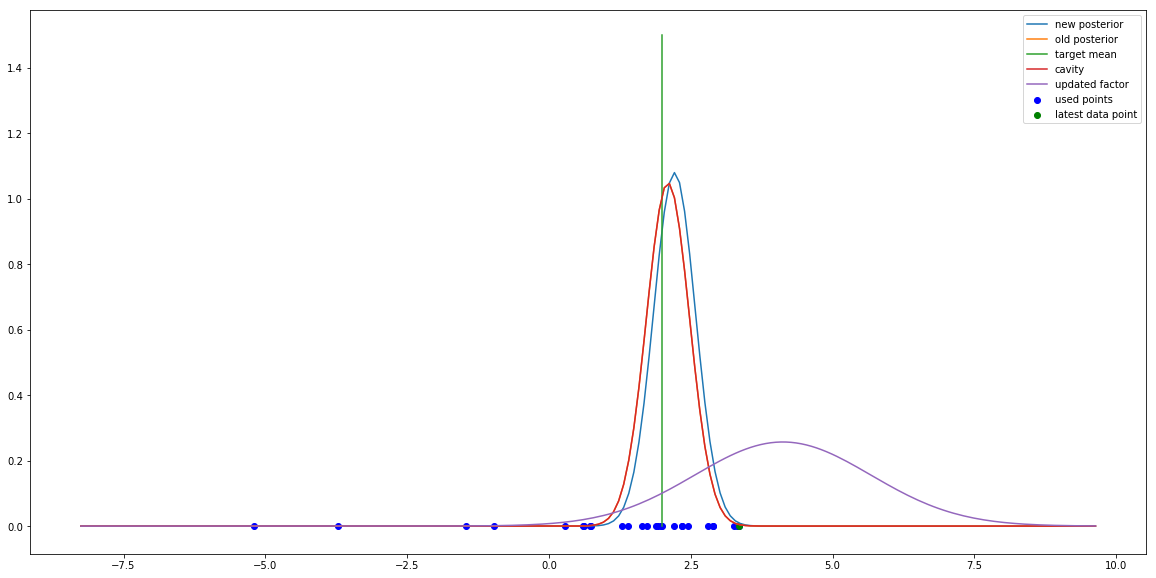

factor  27
mean of factor  -87.3096683959


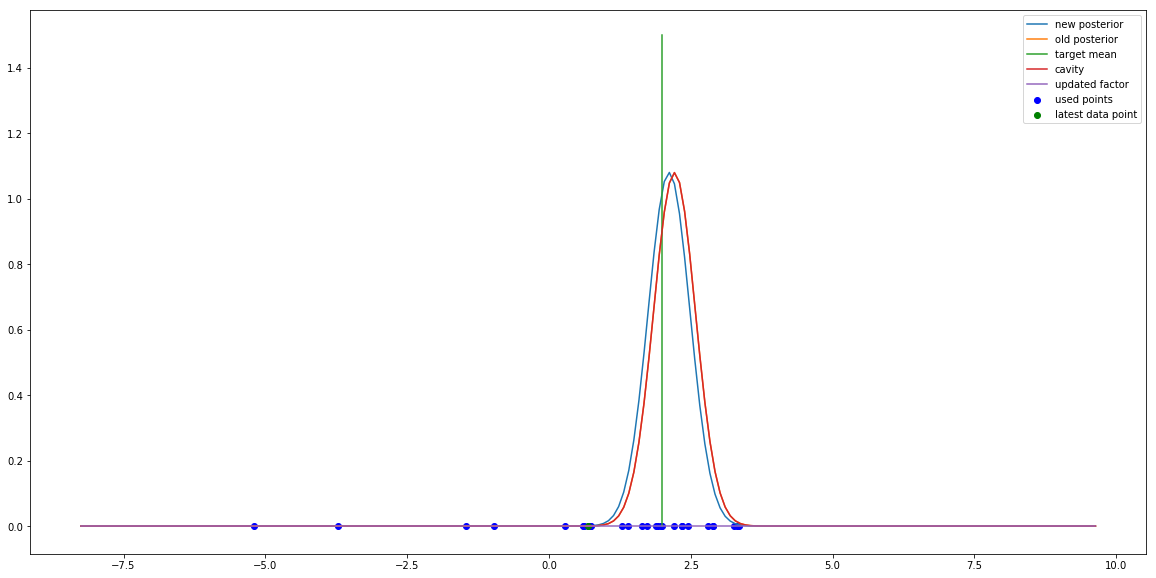

factor  28
mean of factor  2.35058437718


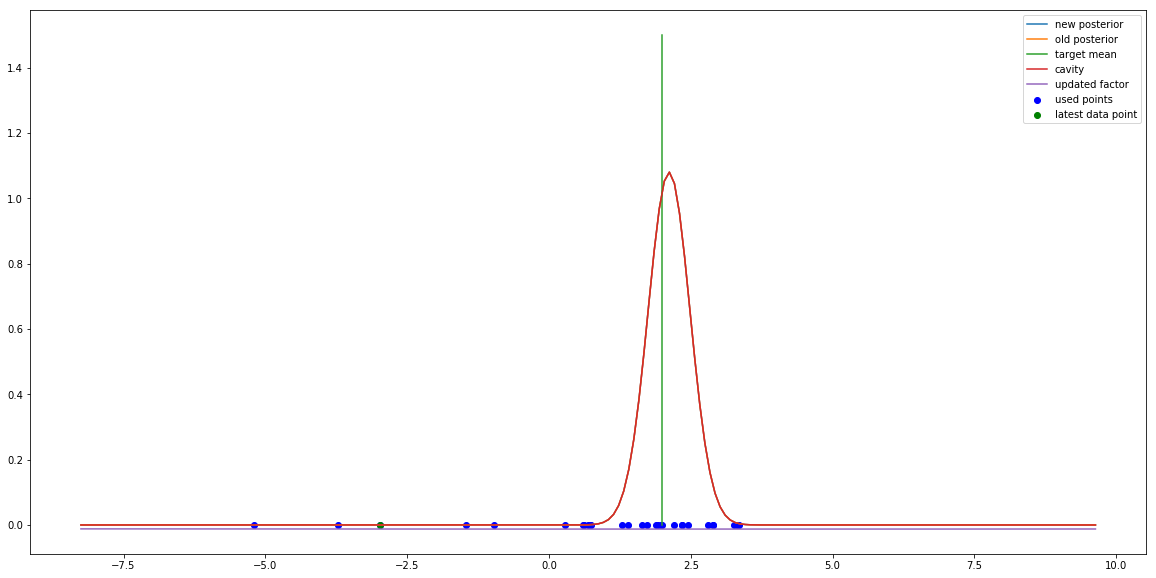

factor  29
mean of factor  2.28345834994


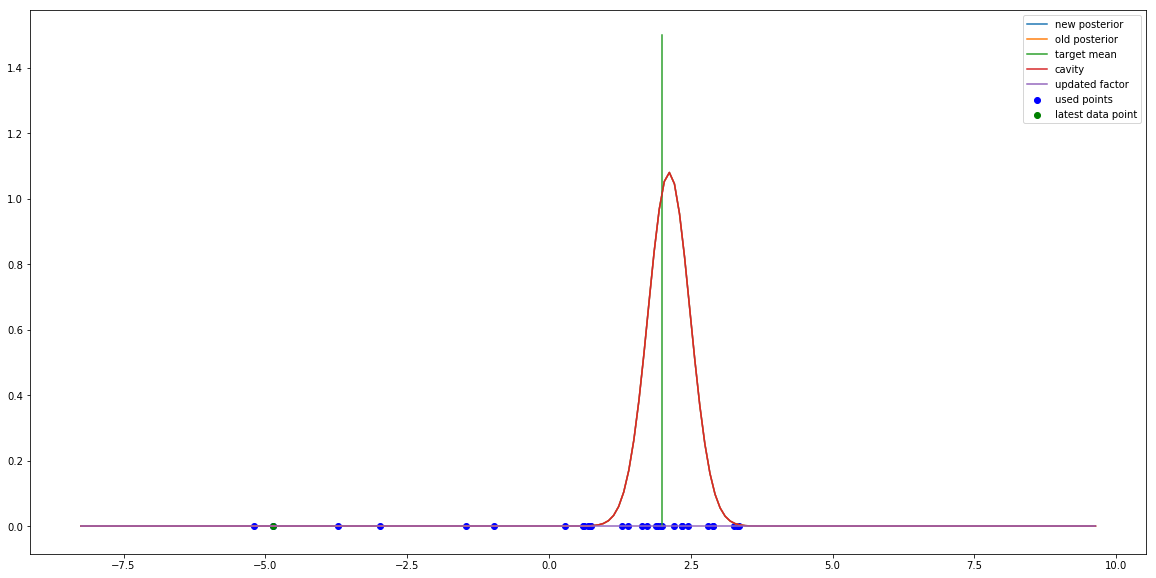

factor  30
mean of factor  1.10265914673


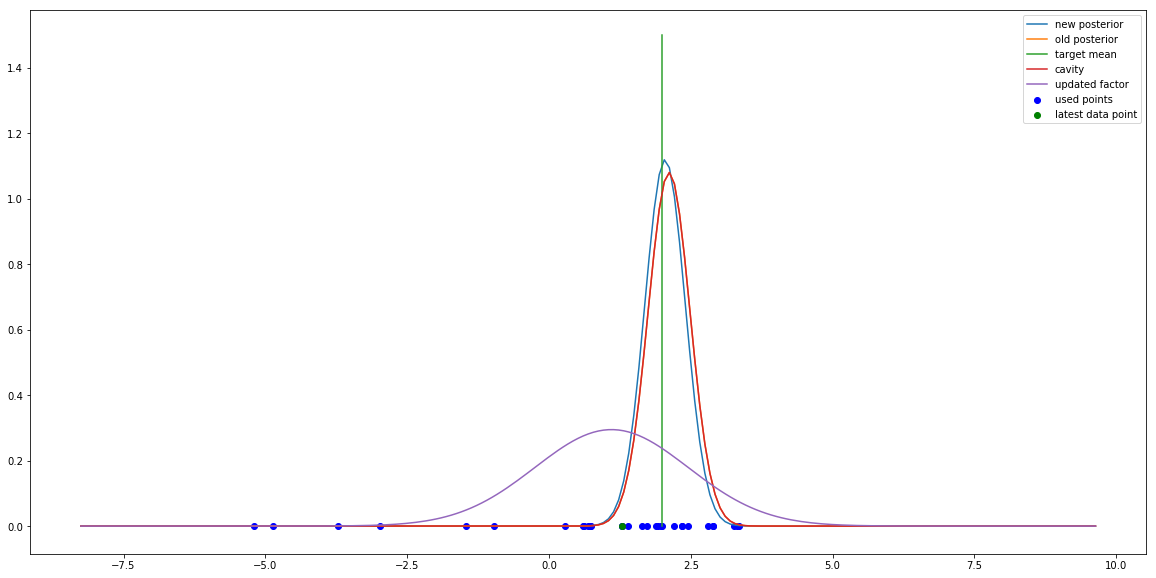

factor  31
mean of factor  0.962023365837


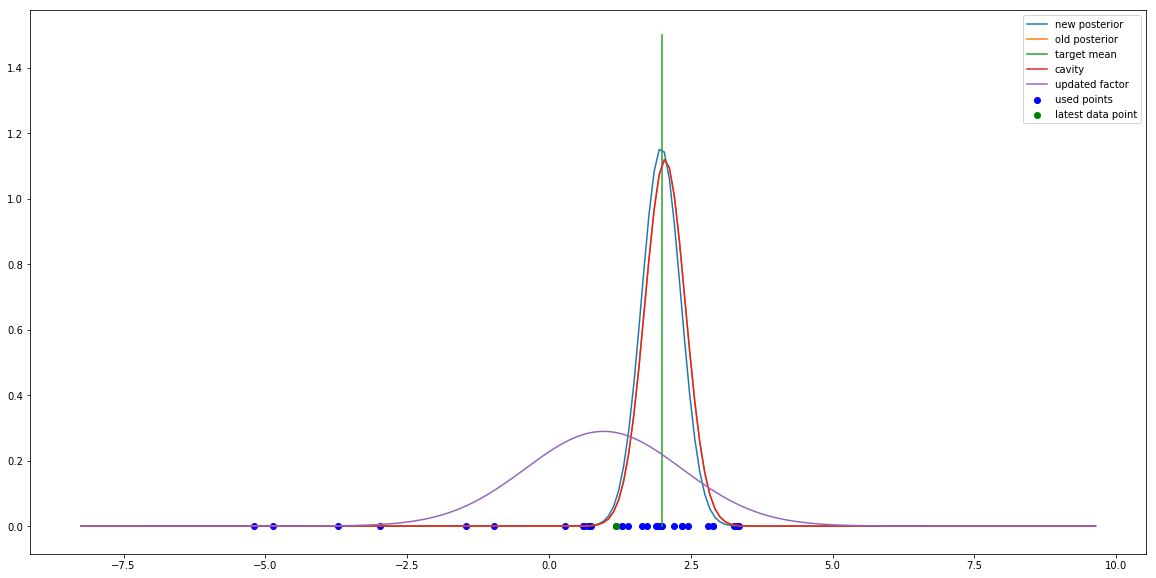

factor  32
mean of factor  2.30642909876


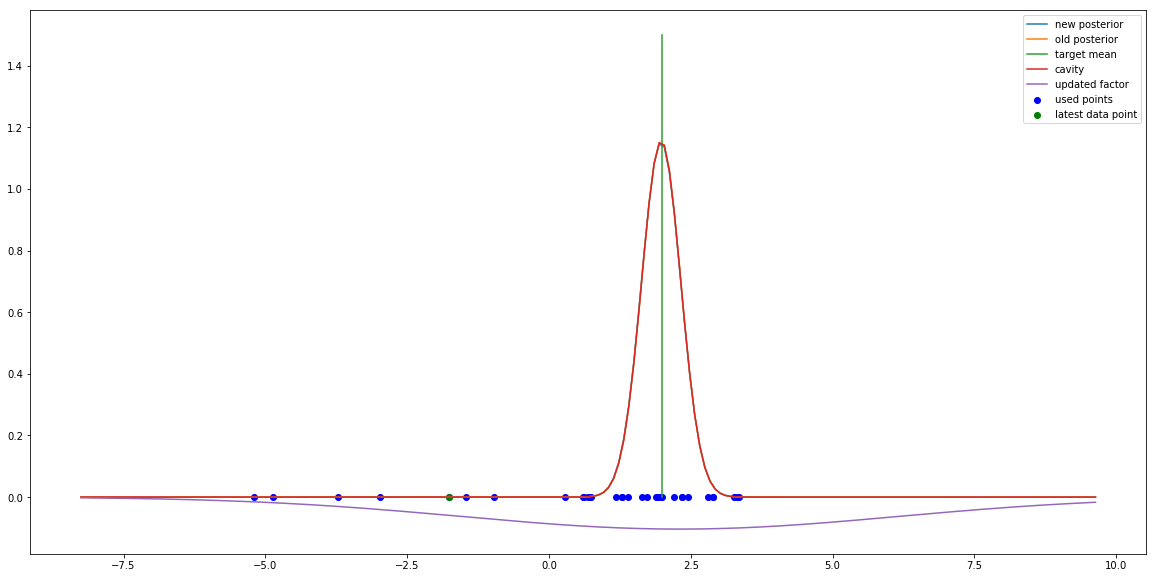

factor  33
mean of factor  2.56247839045


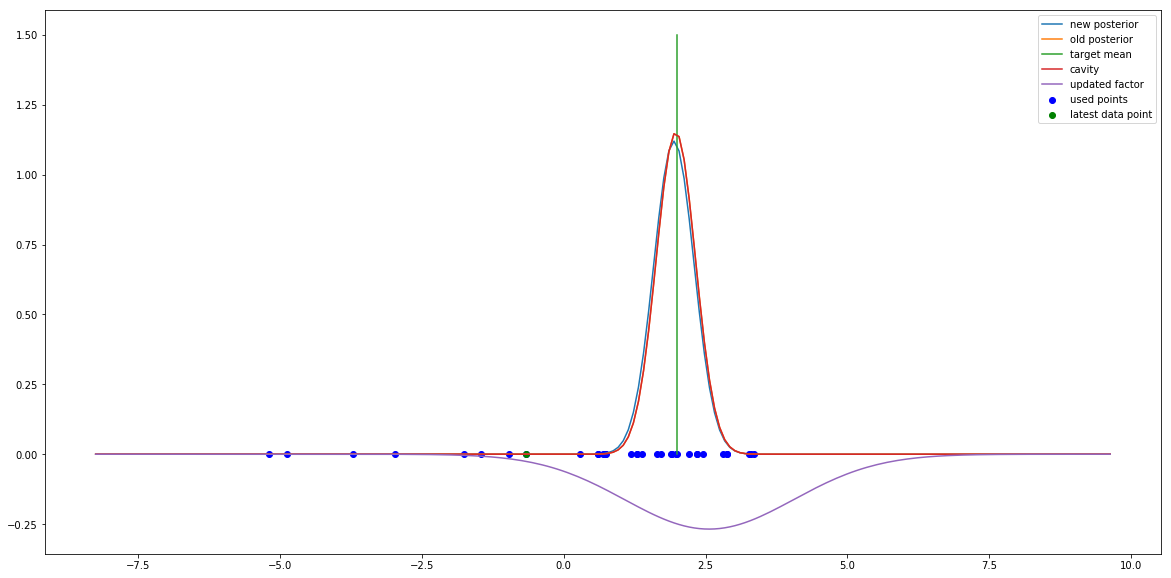

factor  34
mean of factor  2.31601453836


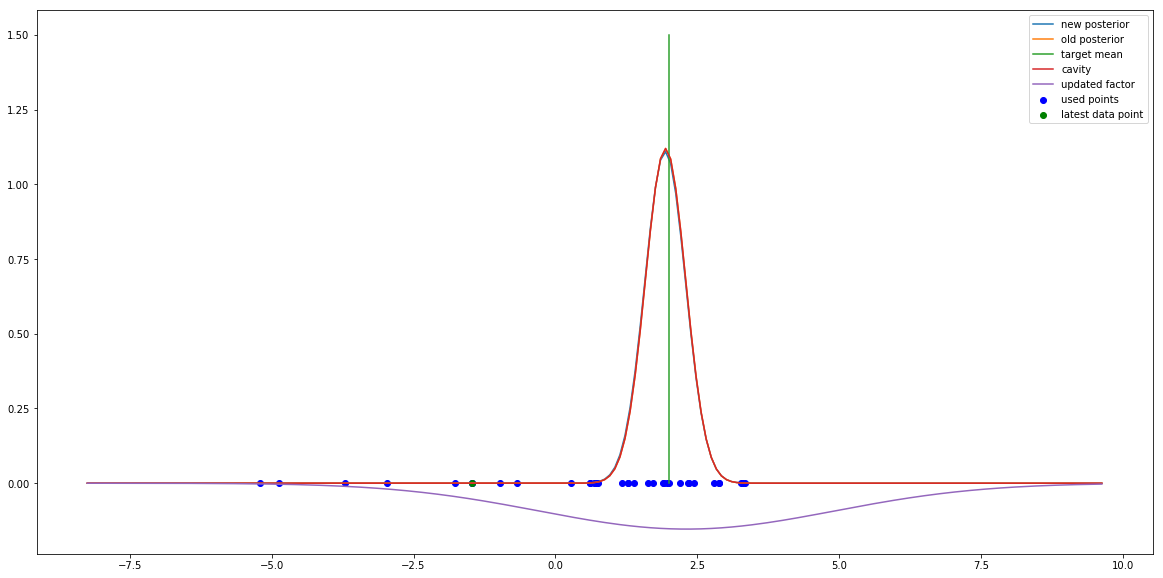

factor  35
mean of factor  2.53085578742


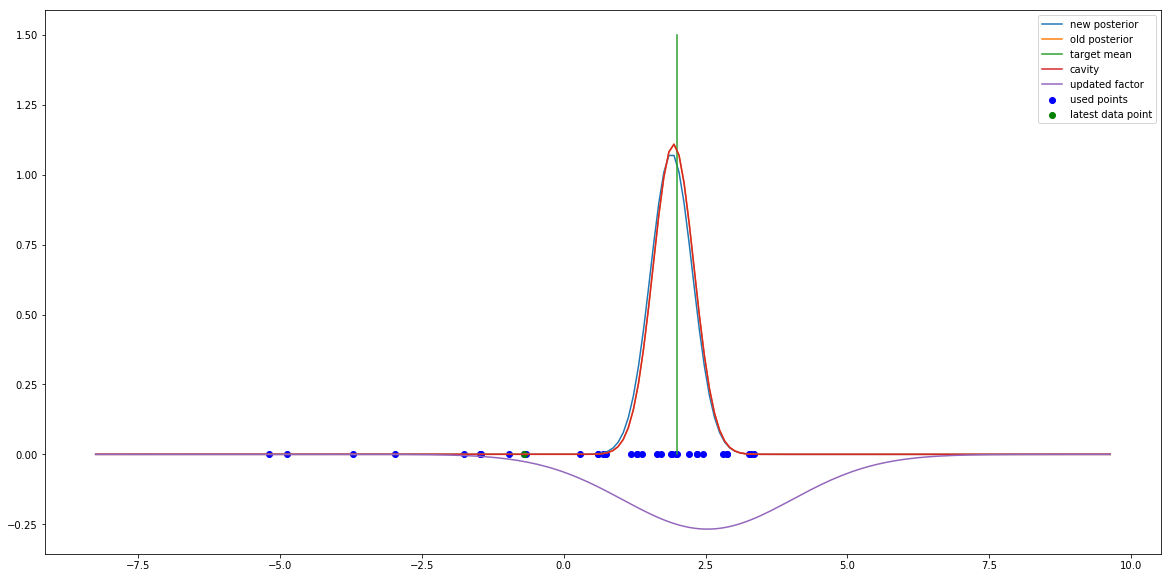

factor  36
mean of factor  2.02571428571


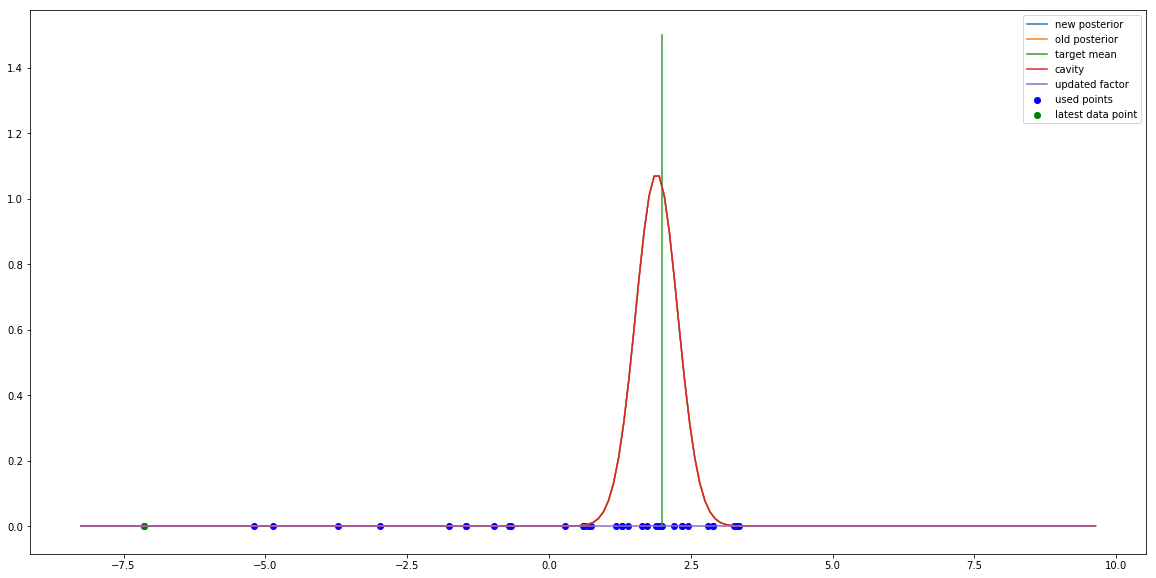

factor  37
mean of factor  -0.162090213138


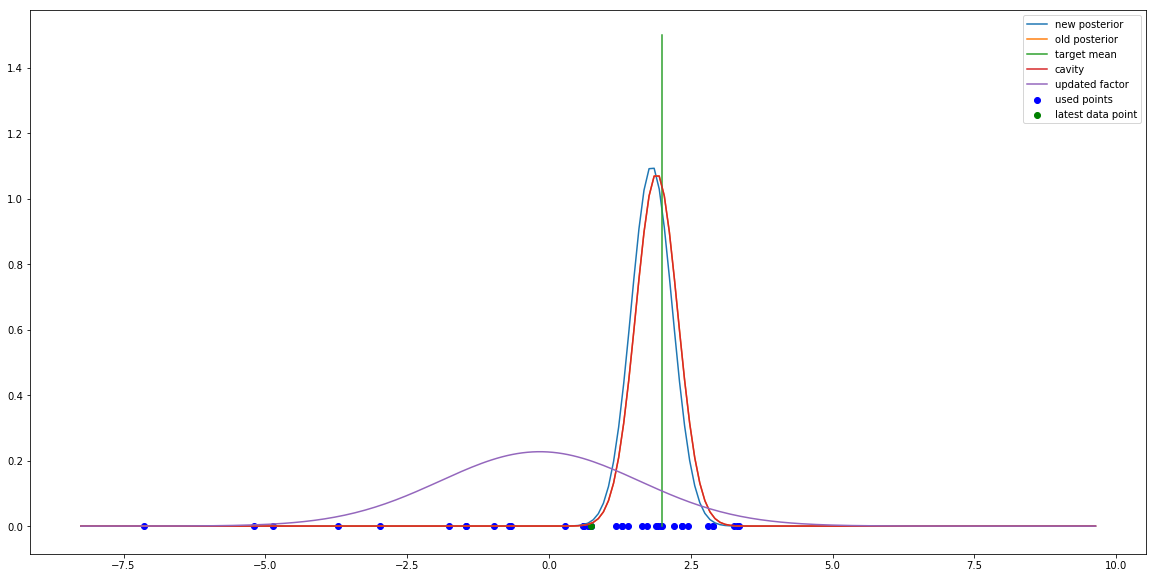

factor  38
mean of factor  2.15613414245


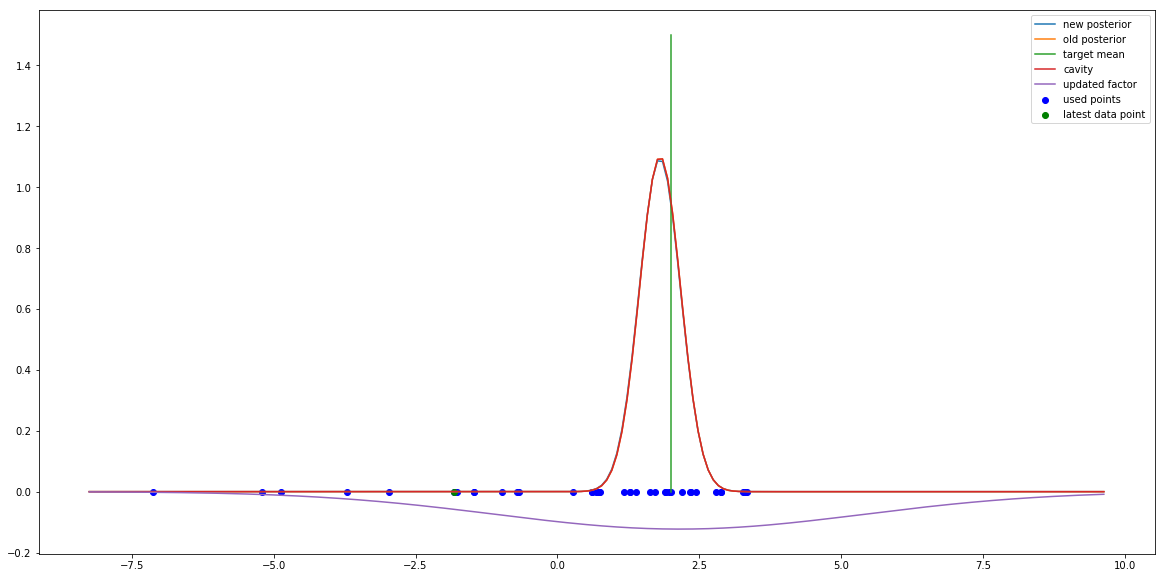

factor  39
mean of factor  3.93864078027


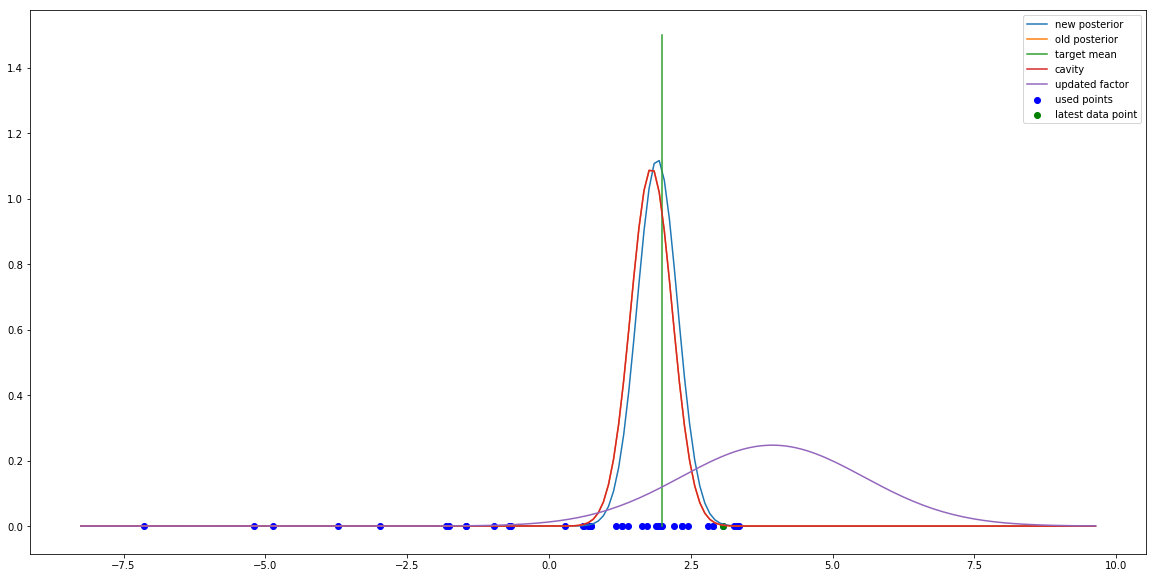

factor  40
mean of factor  2.64838564624


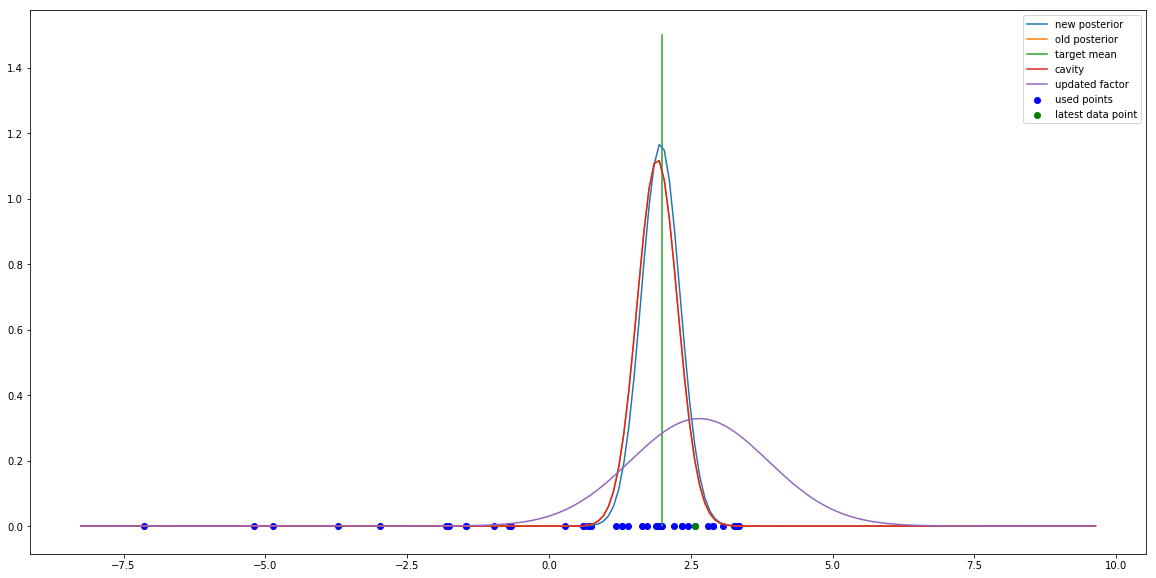

factor  41
mean of factor  1.39739818345


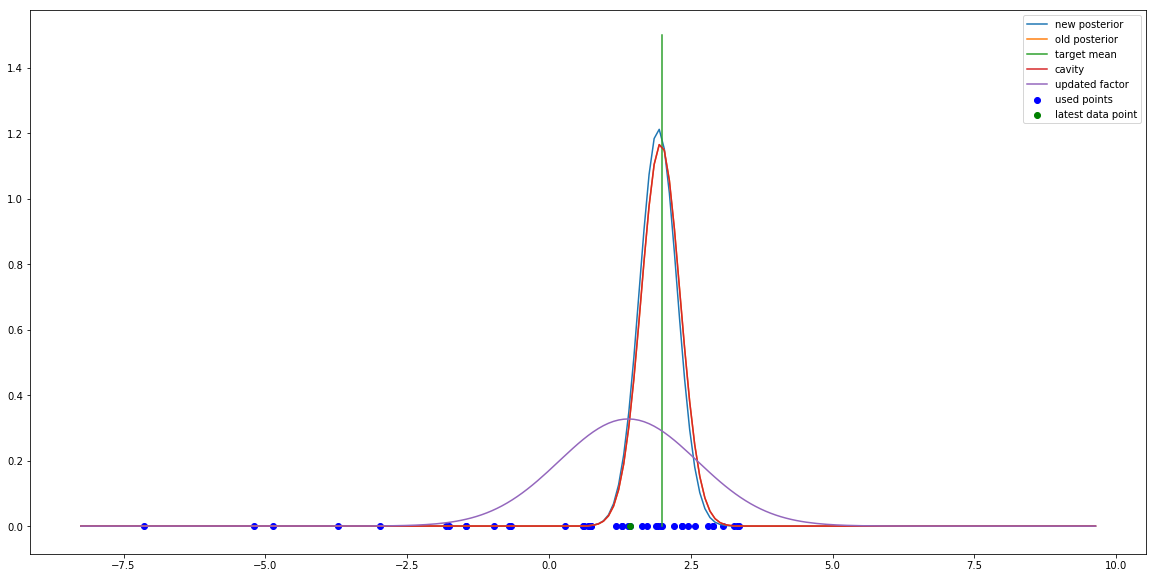

factor  42
mean of factor  2.2088410052


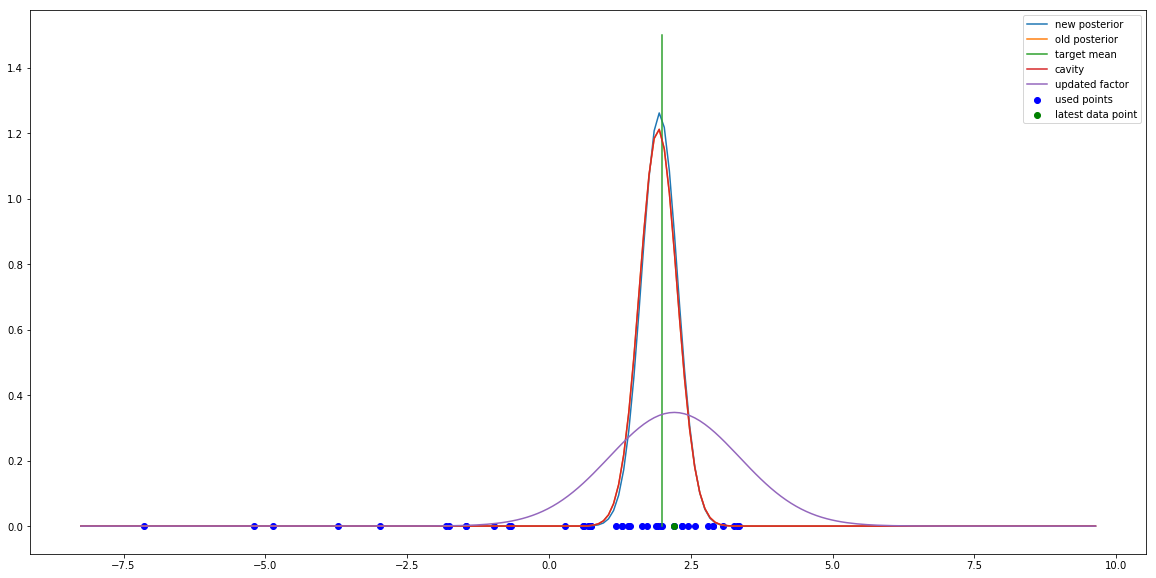

factor  43
mean of factor  -0.0027021786906


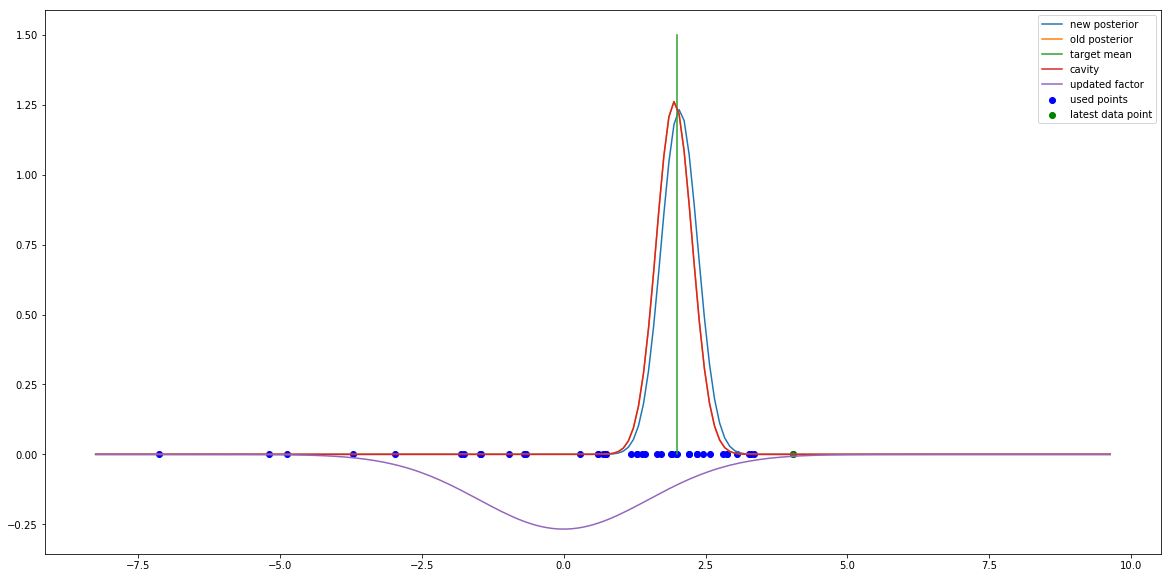

factor  44
mean of factor  1.64713112672


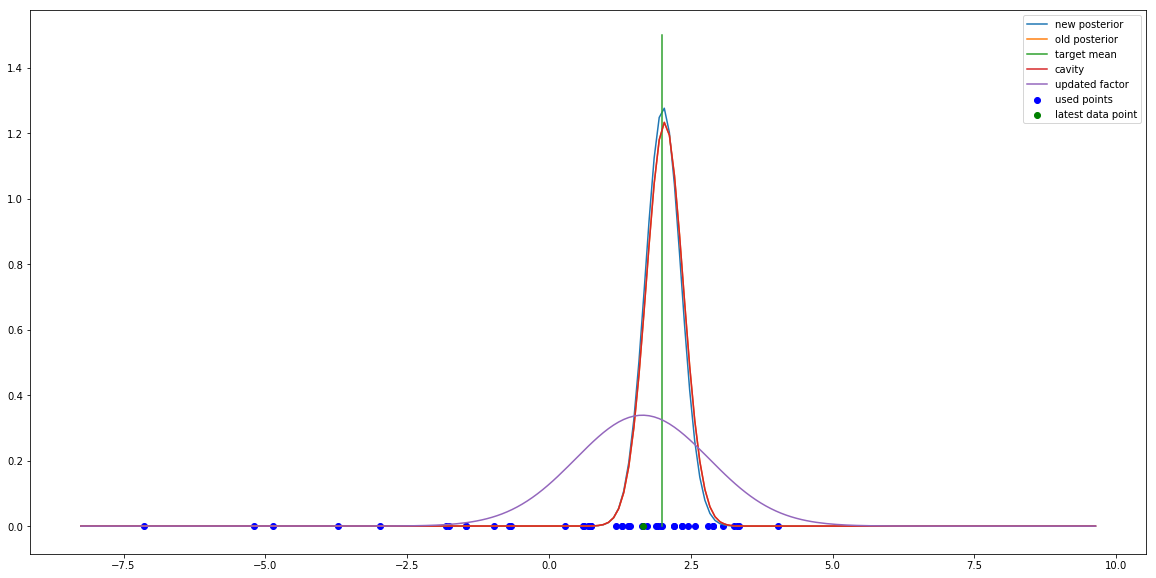

factor  45
mean of factor  2.32572460861


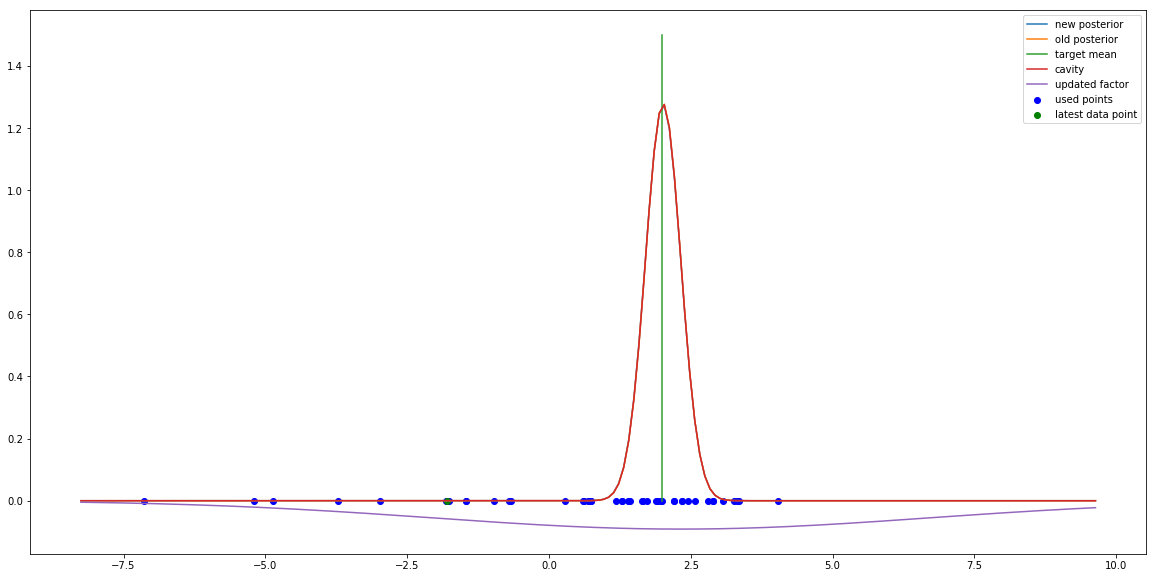

factor  46
mean of factor  0.800177103177


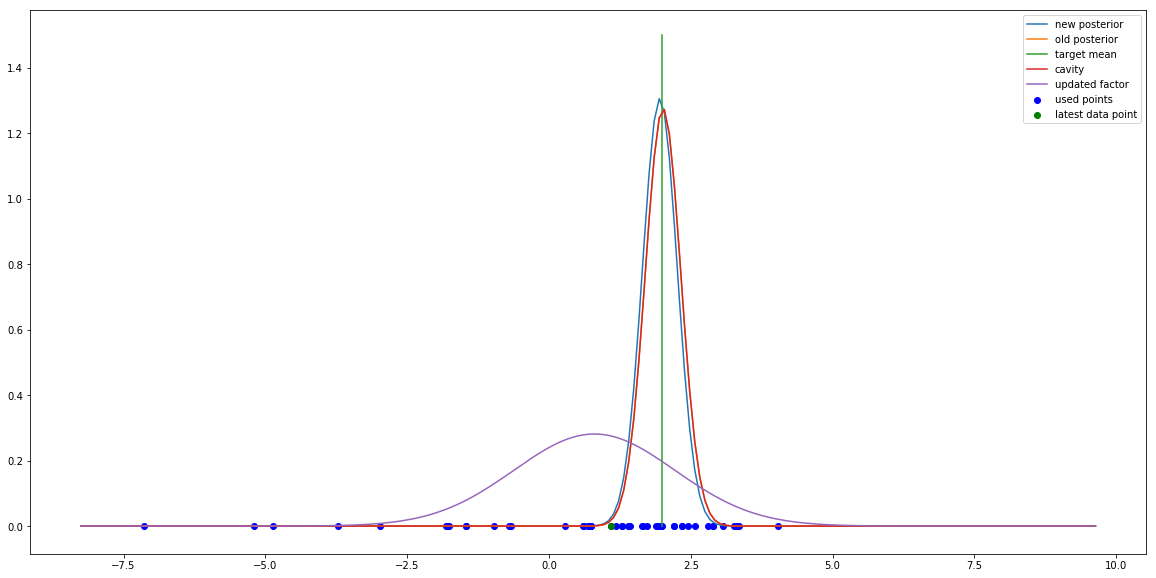

factor  47
mean of factor  2.14104437283


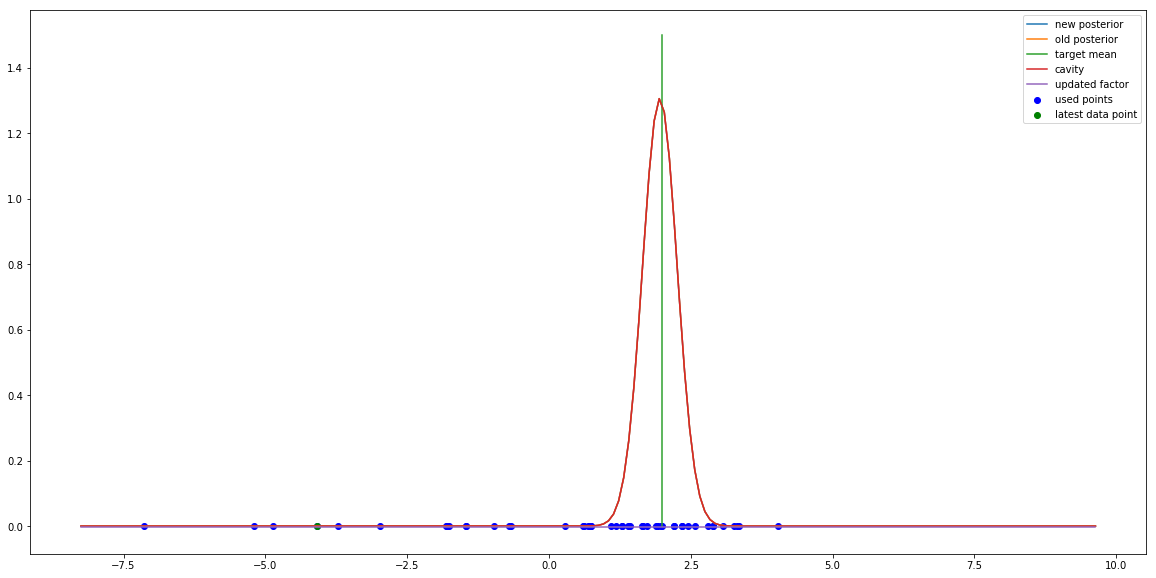

factor  48
mean of factor  2.79294584439


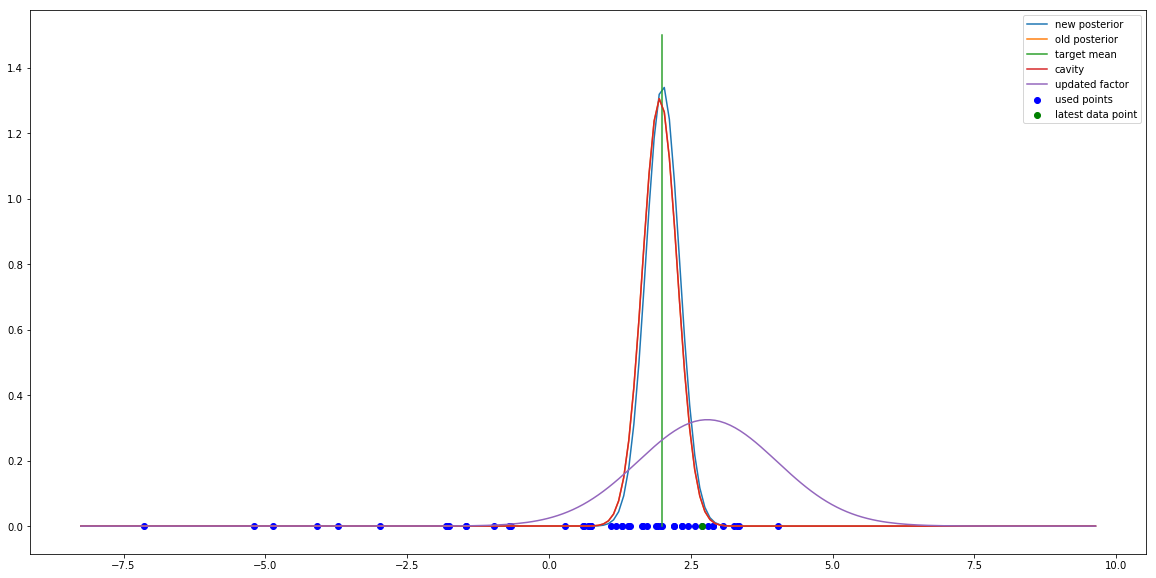

factor  49
mean of factor  1.85954700749


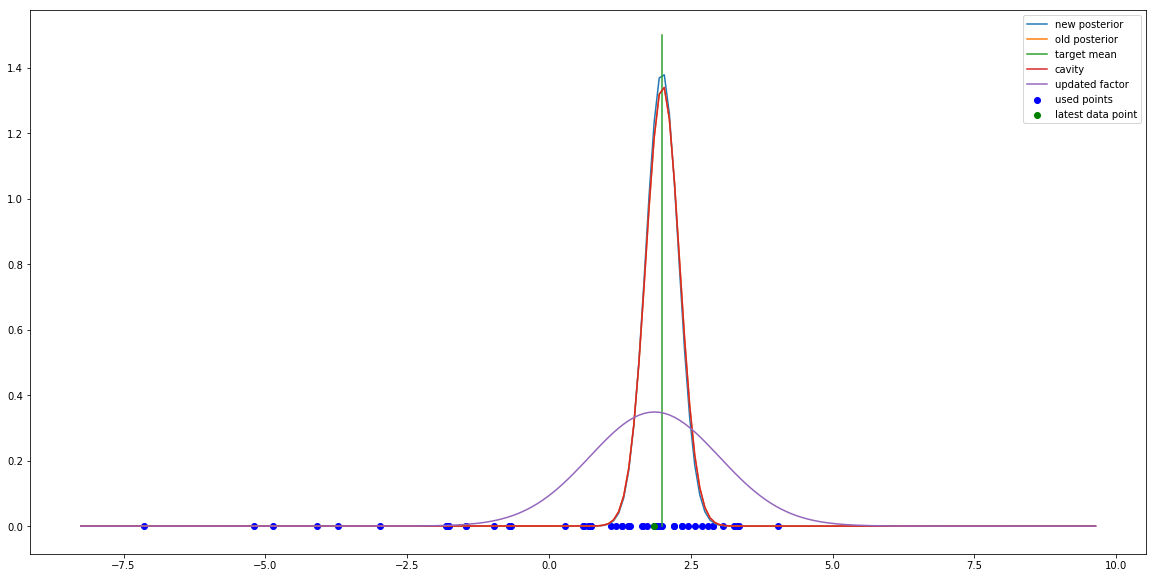

/home/felix/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in square


m_new =  [ 1.99446856]  v_new =  0.0823237320898
Maximum distance from last parameter values:  inf
Iteration  1
factor  0
mean of factor  1.62948128374


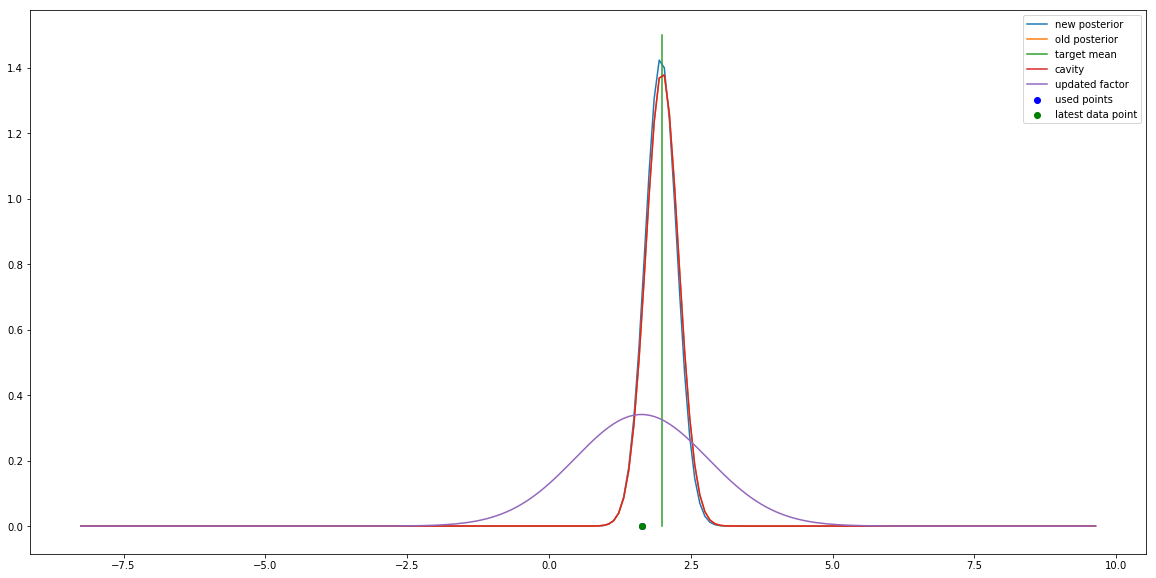

factor  1
mean of factor  2.41997321797


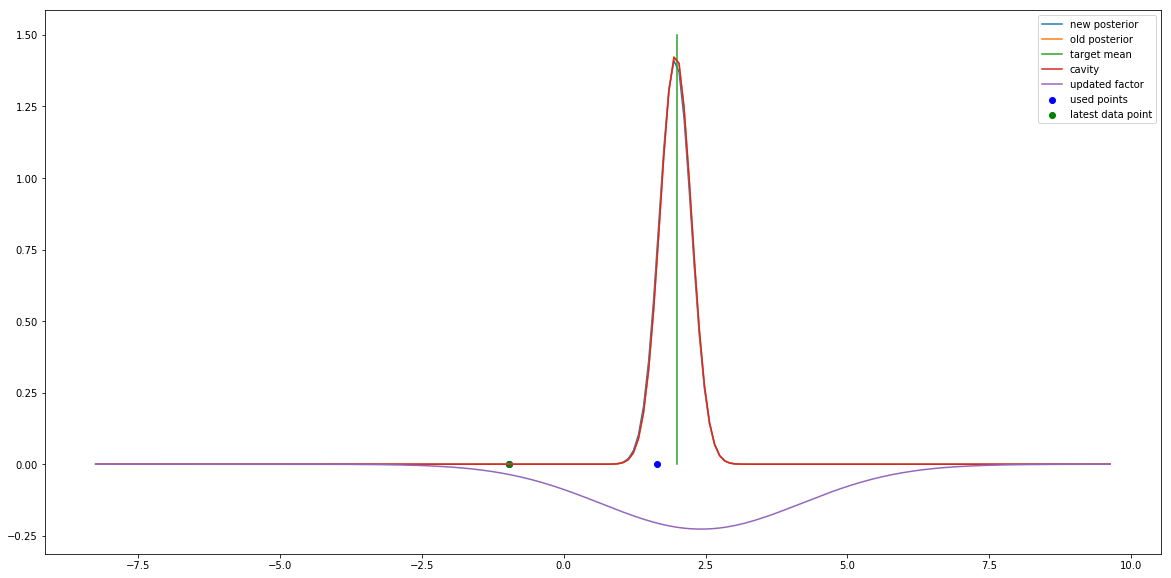

factor  2
mean of factor  1.97210996942


KeyboardInterrupt: 

In [24]:
# Outer loop
for iteration in xrange(10):
    print "Iteration ", iteration

    factors_used = []

    for i in xrange(N):
        print "factor ", i
        
        
        m_old = m_new
        v_old = v_new
        ######################################################################################
        
        # Find the cavity distribution parameters.
        
        if division_zero(vi[i], v_new):
            cavity_m, cavity_v = remove_factor(mi[i], vi[i], m_new, v_new)
        else:
            print "Skipping ", i, " for division of zero when removing factor for cavity funtion iiii"
            continue
  
        ######################################################################################

        # minimise KL divergence, update posterior
        
        m_new, v_new, Zi = minimise_KL_divergence(data[i], cavity_m, cavity_v)

        ######################################################################################

        # Update/remove approximate factor fi from q_new (moment matched from min KL)    
        
        mi[i], vi[i], si[i] = update_approximate_factor(cavity_m, m_new, cavity_v, v_new, Zi)

        ######################################################################################    
    
        factors_used.append(i)
        update_plot(data, m_new, v_new, cavity_m, cavity_v, mi, vi, factors_used, x_true, pclutter, m_old, v_old)
        
        ###################################################################################### 

        
    # Check for convergence, after iteration
    if check_convergence(mi, vi, si, old_mi, old_vi, old_si):
        print "Convergence reached."
        break
        
    old_vi = copy.copy(vi)
    old_mi = copy.copy(mi)
    old_si = copy.copy(si)


In [ ]:
#######################################################################################################

# Compute the normalising constant for posterior

valid_factors = (vi > 0) & np.isfinite(si)
B = m_new.dot(m_new) / v_new - sum(m.dot(m) / v for (m, v) in
                             izip(mi[valid_factors], vi[valid_factors]))
Z = ((2 * np.pi * v_new) ** (.5 * d) * np.exp(.5 * B)
     * s0 * np.prod(si[valid_factors])
           * np.prod((2 * np.pi * vi[valid_factors]) ** (-.5 * d)))

########################################################################################################
print "Results:"
print "vi = ", vi
print "mi = ", mi
print "si = ", si
print "m_posterior = ", m_new
print "v_posterior = ", v_new
print "B = ", B
print "Z = ", Z

plot_factors(data, x_true, m0, v0, mi, vi)

